In [1]:
from matplotlib import pyplot as plt
import matplotlib
from sklearn import preprocessing
import os
import numpy as np
import random as rd
import tensorflow as tf 
tf.compat.v1.disable_eager_execution()
sess  = tf.compat.v1.InteractiveSession()
from scipy.integrate import odeint
import pickle
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
import scipy
import joblib
from mpl_toolkits import mplot3d

from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D


In [2]:
# Number of time points we want for the solutions
n = 101

# Time points we want for the solution
t = np.linspace(0, 20, n)

# Parameters
beta_y = 5.0
beta_z = 5.0
gamma = 1.0
n_x = 2
n_y = 3
x_0 = 2.0
Km1 = 1
Km2 = 2
delta = 0.18

# Package parameters into a tuple
args = (beta_y, beta_z, gamma, n_x, n_y, Km1, Km2, delta, x_0)

def toggle_switch(yz, t, beta_y, beta_z, gamma, n_x, n_y, Km1, Km2, delta, x):
    """
    Right hand side for cascade X -> Y -> Z.  Return dy/dt and dz/dt.
    """
    # Unpack y and z
    y, z = yz
    
    # Compute dy/dt
    dy_dt = beta_y/ (Km1 + z**n_x) - delta*y
    
    # Compute dz/dt
    dz_dt = gamma * (beta_z/ (Km2 + y**n_y) - delta*z)
    
    # Return the result as a NumPy array
    return np.array([dy_dt, dz_dt])

In [3]:
sess1 = tf.compat.v1.InteractiveSession()
saver = tf.compat.v1.train.import_meta_graph('Checkpoint_files/Toggle_switch_DMJ.pickle.ckpt.meta', clear_devices=True)
saver.restore(sess1, tf.train.latest_checkpoint('Checkpoint_files'))

scaler_filename = 'Checkpoint_files/Toggle_Switch_DMJ_scaler.save'
scaler = joblib.load(scaler_filename) 

psixpT = tf.compat.v1.get_collection('psiyp')[0]
psixfT = tf.compat.v1.get_collection('psiyf')[0]
xpT_feed = tf.compat.v1.get_collection('yp_feed')[0]
xfT_feed = tf.compat.v1.get_collection('yf_feed')[0]
KxT = tf.compat.v1.get_collection('Kx')[0]
KxT_num = sess1.run(KxT)


/Users/dennisjoshy/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from Checkpoint_files/Toggle_switch_DMJ.pickle.ckpt


In [4]:
KxT_num

array([[ 9.6188217e-01, -4.0935911e-04,  2.2178654e-04, -1.4898893e-04,
         0.0000000e+00],
       [-1.6495824e-03,  9.6469599e-01,  3.9417506e-04,  3.2272386e-05,
         0.0000000e+00],
       [-8.9798653e-01,  1.0871733e-01,  1.0082504e+00, -1.1233694e-03,
         0.0000000e+00],
       [ 9.1696516e-02,  8.3428162e-01,  8.9456905e-03,  1.0053438e+00,
         0.0000000e+00],
       [ 2.9434919e-02,  4.8213103e-01,  5.0227051e-03,  3.4844128e-03,
         1.0000000e+00]], dtype=float32)

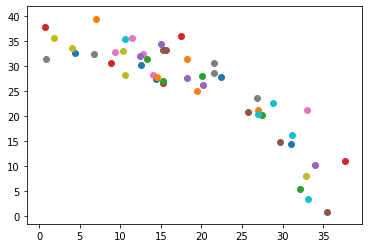

In [5]:
ICs = []
num_ics = 50
for i in range(0, num_ics):
    r = rd.uniform(30, 40)
    theta = rd.uniform(0, 1.57)
    ICs.append([r*np.cos(theta), r*np.sin(theta)])
    
for i in range(0, num_ics):
    plt.scatter(ICs[i][0],ICs[i][1])

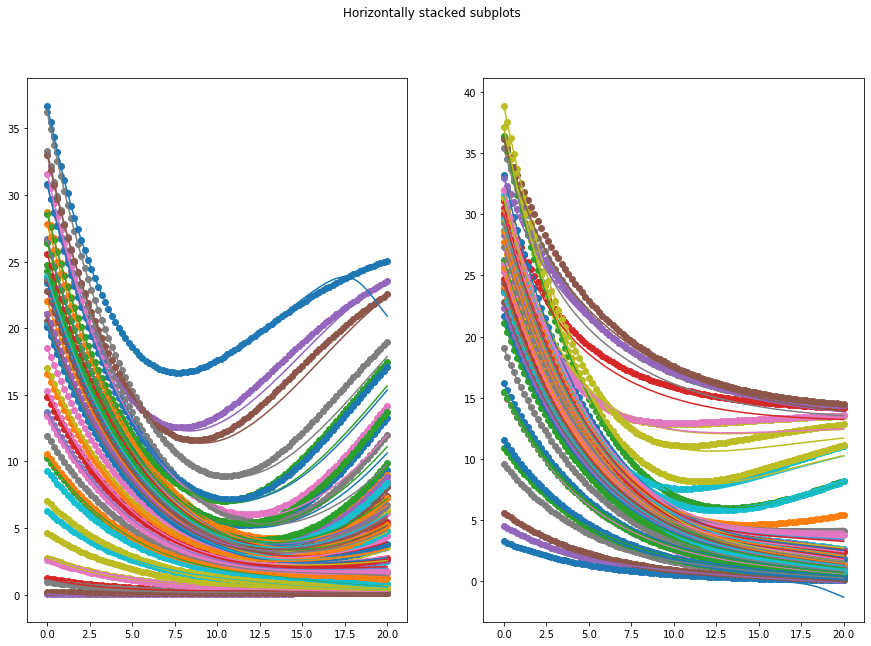

In [10]:
Xp_final_learned = []
Xf_final_learned = []
Xp_final_actual = []
Xf_final_actual = []
#t = np.array([i for i in range(0, N+1)])
x_learned = np.zeros(2)
x_actual = np.zeros(2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
fig.suptitle('Horizontally stacked subplots')
for ic in ICs:
    ic_s = scaler.transform(np.array([ic]))
    x_learned = np.array(ic_s)
    x_actual[0] = ic[0]
    x_actual[1] = ic[1]
    X_learned = []
    X_actual = []
    X_learned.append([x_learned[0][0], x_learned[0][1]]) ## ICs
    X_actual.append(np.array([x_actual[0], x_actual[1]])) 
    for k in range(0, n-1):
        y_learned = np.matmul(KxT_num.T, psixpT.eval(feed_dict={xpT_feed: x_learned}).T)[0:2].T
        x_learned = y_learned
        X_learned.append([x_learned[0][0], x_learned[0][1]]) 
        #print(k)
    X_actual = scipy.integrate.odeint(toggle_switch, x_actual, t, args=args)
    #Xp_learned = X_learned[0:-1]
    #Xf_learned = X_learned[1:]
    #Xp_actual = X_actual[0:-1]
    #Xf_actual = X_actual[1:]   
    X_learned = scaler.inverse_transform(X_learned)
    ax1.scatter(t, np.array(X_actual).T[0])
    ax1.plot(t, np.array(X_learned).T[0])
    ax2.scatter(t, np.array(X_actual).T[1])
    ax2.plot(t, np.array(X_learned).T[1])
    #Xp_final_learned = Xp_final_learned + Xp_learned
    #Xf_final_learned = Xf_final_learned + Xf_learned
    #Xp_final_actual = Xp_final_actual + Xp_actual
    #Xf_final_actual = Xf_final_actual + Xf_actual
    

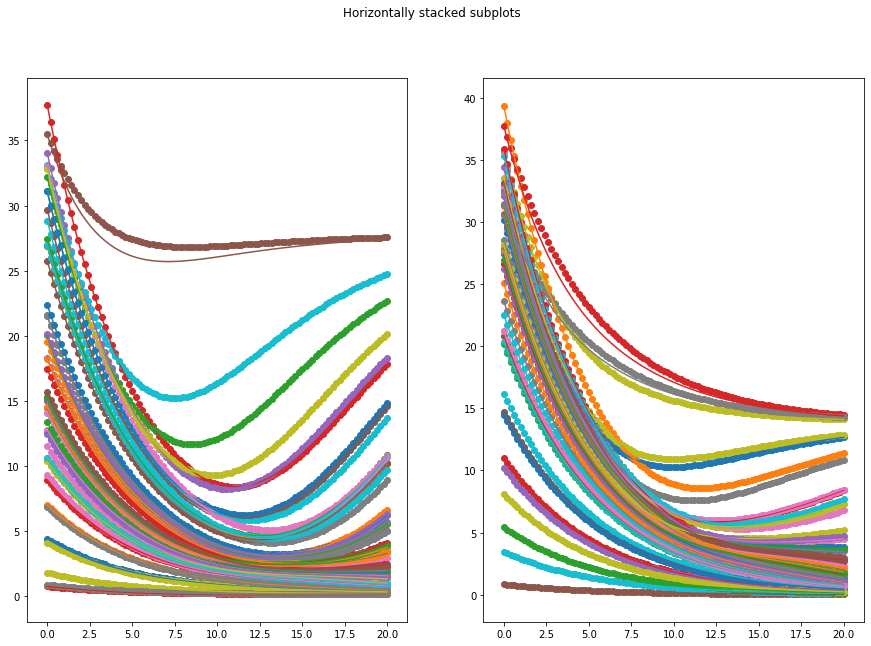

In [6]:

Xp_final_learned = []
Xf_final_learned = []
Xp_final_actual = []
Xf_final_actual = []
#t = np.array([i for i in range(0, N+1)])
x_learned = np.zeros(2)
x_actual = np.zeros(2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
fig.suptitle('Horizontally stacked subplots')
for ic in ICs:
    ic_s = scaler.transform(np.array([ic]))
    x_learned = np.array(ic_s)
    x_actual[0] = ic[0]
    x_actual[1] = ic[1]
    X_learned = []
    X_actual = []
    X_learned.append([x_learned[0][0], x_learned[0][1]]) ## ICs
    X_actual.append(np.array([x_actual[0], x_actual[1]])) 
    for k in range(0, n-1):
        y_learned = np.matmul(KxT_num.T, psixpT.eval(feed_dict={xpT_feed: x_learned}).T)[0:2].T
        x_learned = y_learned
        X_learned.append([x_learned[0][0], x_learned[0][1]]) 
        #print(k)
    X_actual = scipy.integrate.odeint(toggle_switch, x_actual, t, args=args)
    #Xp_learned = X_learned[0:-1]
    #Xf_learned = X_learned[1:]
    #Xp_actual = X_actual[0:-1]
    #Xf_actual = X_actual[1:]   
    X_learned = scaler.inverse_transform(X_learned)
    ax1.scatter(t, np.array(X_actual).T[0])
    ax1.plot(t, np.array(X_learned).T[0])
    ax2.scatter(t, np.array(X_actual).T[1])
    ax2.plot(t, np.array(X_learned).T[1])
    #Xp_final_learned = Xp_final_learned + Xp_learned
    #Xf_final_learned = Xf_final_learned + Xf_learned
    #Xp_final_actual = Xp_final_actual + Xp_actual
    #Xf_final_actual = Xf_final_actual + Xf_actual
    

In [ ]:
sess1.close()

In [7]:
x1 = np.linspace(0, 20, n)
x2 = np.linspace(0, 20, n)

x_c = np.linspace(-10, 10, n)
y_c = np.linspace(-10, 10, n)

X, Y = np.meshgrid(x_c, y_c)

#psixpT.eval(feed_dict={xpT_feed: x_learned}).T[2]
grid = [[np.array([[i, j]]) for i in x1] for j in x2]

In [8]:
z1 = np.zeros((x1.shape[0], x1.shape[0]))
z2 = np.zeros((x1.shape[0], x1.shape[0]))
Psi = []
for i in range(0, len(grid)):
    for j in range(0, len(grid)):
        z1[i][j] = psixpT.eval(feed_dict={xpT_feed: grid[i][j]}).T[2]
        z2[i][j] = psixpT.eval(feed_dict={xpT_feed: grid[i][j]}).T[3]
        Psi.append([z1[i][j], z2[i][j]])
Psi = np.array(Psi)

In [9]:
scaled_Psi_obs1 = scaler.inverse_transform(Psi)[:, 0].reshape(len(grid), len(grid))
scaled_Psi_obs2 = scaler.inverse_transform(Psi)[:, 1].reshape(len(grid), len(grid))

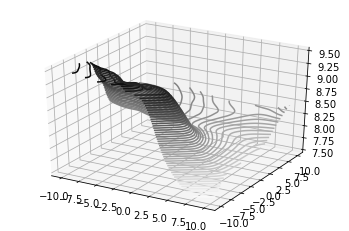

In [75]:
fig = plt.figure()
ax  = plt.axes(projection='3d')
ax.contour3D(X, Y, scaled_Psi_obs1, 50, cmap='binary')

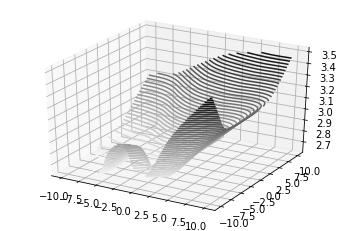

In [76]:
fig = plt.figure()
ax  = plt.axes(projection='3d')
ax.contour3D(X, Y, scaled_Psi_obs2, 50, cmap='binary')

def gaussian(x, y, x0, y0, xalpha, yalpha, A):
    return A * np.exp( -((x-x0)/xalpha)**2 -((y-y0)/yalpha)**2)

# A list of the Gaussian parameters: x0, y0, xalpha, yalpha, A
gprms = [(0, 2, 2.5, 5.4, 1.5),
         (-1, 4, 6, 2.5, 1.8),
         (-3, -0.5, 1, 2, 4),
         (3, 0.5, 2, 1, 5)
        ]

# Standard deviation of normally-distributed noise to add in generating
# our test function to fit.
noise_sigma = 0.1

# The function to be fit is Z.
Z = np.zeros(X.shape)
for p in gprms:
    Z += gaussian(X, Y, *p)
Z += noise_sigma * np.random.randn(*Z.shape)

# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, cmap='plasma')
ax.set_zlim(0,np.max(Z)+2)
plt.show()

# This is the callable that is passed to curve_fit. M is a (2,N) array
# where N is the total number of data points in Z, which will be ravelled
# to one dimension.
def _gaussian(M, *args):
    x, y = M
    arr = np.zeros(x.shape)
    for i in range(len(args)//5):
       arr += gaussian(x, y, *args[i*5:i*5+5])
    return arr

# Initial guesses to the fit parameters.
guess_prms = [(0, 0, 1, 1, 2),
              (-1.5, 5, 5, 1, 3),
              (-4, -1, 1.5, 1.5, 6),
              (4, 1, 1.5, 1.5, 6.5)
             ]
# Flatten the initial guess parameter list.
p0 = [p for prms in guess_prms for p in prms]

# We need to ravel the meshgrids of X, Y points to a pair of 1-D arrays.
xdata = np.vstack((X.ravel(), Y.ravel()))
# Do the fit, using our custom _gaussian function which understands our
# flattened (ravelled) ordering of the data points.
popt, pcov = curve_fit(_gaussian, xdata, Z.ravel(), p0)
fit = np.zeros(Z.shape)
for i in range(len(popt)//5):
    fit += gaussian(X, Y, *popt[i*5:i*5+5])
print('Fitted parameters:')
print(popt)

rms = np.sqrt(np.mean((Z - fit)**2))
print('RMS residual =', rms)

# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, fit, cmap='plasma')
cset = ax.contourf(X, Y, Z-fit, zdir='z', offset=-4, cmap='plasma')
ax.set_zlim(-4,np.max(fit))
plt.show()

# Plot the test data as a 2D image and the fit as overlaid contours.
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(Z, origin='bottom', cmap='plasma',
          extent=(x.min(), x.max(), y.min(), y.max()))
ax.contour(X, Y, fit, colors='w')
plt.show()

## Hill function fitting

In [132]:
x1 = np.linspace(0, 20, n)
x2 = np.linspace(0, 20, n)

#x_c = np.linspace(-10, 10, n)
#y_c = np.linspace(-10, 10, n)

X, Y = np.meshgrid(x1, x2)

#psixpT.eval(feed_dict={xpT_feed: x_learned}).T[2]

def hill_function2D(x, y, n1, n2, K11N, K12N, K11D, K12D, y_max, y_min):
    return (y_max - y_min)*((x/K11N)**n1 + (y/K12N)**n2)/(1 + (x/K11D)**n1 + (y/K12D)**n2) + y_min

# A list of the Hill function parameters: x0, y0, xalpha, yalpha, A
hf_prms = [(2, 2, 20, 15, 12.5, 13, 10, 15)]

# The function to be fit is Z.
Z = np.zeros(X.shape)
for p in hf_prms:
    Z += hill_function2D(X, Y, *p)

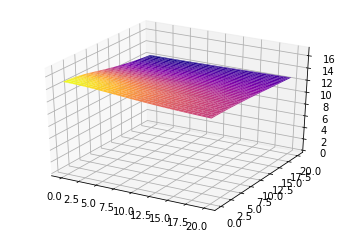

In [96]:
# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, cmap='plasma')
ax.set_zlim(0,np.max(Z)+2)
plt.show()

In [148]:
# This is the callable that is passed to curve_fit. M is a (2,N) array
# where N is the total number of data points in Z, which will be ravelled
# to one dimension.
def _hill_function2D(M, *args):
    x, y = M
    arr = np.zeros(x.shape)
    print(args)
    for i in range(len(args)//8):
        arr += hill_function2D(x, y, *args[i*8:i*8+8])
    return arr

In [163]:
# We need to ravel the meshgrids of X, Y points to a pair of 1-D arrays.
xdata = np.vstack((X.ravel(), Y.ravel()))
# Do the fit, using our custom _gaussian function which understands our
# flattened (ravelled) ordering of the data points.

In [176]:
len(learned_params)

9

In [191]:

learned_params = []
# Flatten the initial guess parameter list.
for simulation in range(0, 100):
    print(simulation)
    p0 =  [(np.random.randint(0, 3), np.random.randint(0, 3), np.random.randint(5, 20), np.random.randint(5, 20), np.random.randint(5, 20), np.random.randint(5, 20), np.random.randint(5, 20), np.random.randint(5, 20))]

    popt, pcov = curve_fit(_hill_function2D, xdata, Z.ravel(), p0[0], bounds=(0, np.inf), maxfev = 3000);
    fit = np.zeros(Z.shape);
    
    learned_params.append(popt)

0
(1e-10, 1.0, 18.0, 19.0, 12.0, 14.0, 5.0, 8.0)
(1.5001161193847657e-08, 1.0, 18.0, 19.0, 12.0, 14.0, 5.0, 8.0)
(1e-10, 1.0000000149011612, 18.0, 19.0, 12.0, 14.0, 5.0, 8.0)
(1e-10, 1.0, 18.0000002682209, 19.0, 12.0, 14.0, 5.0, 8.0)
(1e-10, 1.0, 18.0, 19.000000283122063, 12.0, 14.0, 5.0, 8.0)
(1e-10, 1.0, 18.0, 19.0, 12.000000178813934, 14.0, 5.0, 8.0)
(1e-10, 1.0, 18.0, 19.0, 12.0, 14.000000208616257, 5.0, 8.0)
(1e-10, 1.0, 18.0, 19.0, 12.0, 14.0, 5.000000074505806, 8.0)
(1e-10, 1.0, 18.0, 19.0, 12.0, 14.0, 5.0, 8.00000011920929)
(0.3621026240570132, 1.6841265528963356, 17.999999984388236, 7.750781977076372, 12.000000000000007, 14.044590052685207, 11.597759260105148, 15.57952113830955)
(0.3621026389581744, 1.6841265528963356, 17.999999984388236, 7.750781977076372, 12.000000000000007, 14.044590052685207, 11.597759260105148, 15.57952113830955)
(0.3621026240570132, 1.684126577991777, 17.999999984388236, 7.750781977076372, 12.000000000000007, 14.044590052685207, 11.597759260105148, 15.57

(2.0000000298024103, 2.0000000000023963, 34.63794795426695, 25.978460965659988, 12.49999999999679, 12.999999999977783, 0.00265701896222138, 14.999999999999856)
(2.000000000000088, 2.0000000298047187, 34.63794795426695, 25.978460965659988, 12.49999999999679, 12.999999999977783, 0.00265701896222138, 14.999999999999856)
(2.000000000000088, 2.0000000000023963, 34.637948470412596, 25.978460965659988, 12.49999999999679, 12.999999999977783, 0.00265701896222138, 14.999999999999856)
(2.000000000000088, 2.0000000000023963, 34.63794795426695, 25.978461352769223, 12.49999999999679, 12.999999999977783, 0.00265701896222138, 14.999999999999856)
(2.000000000000088, 2.0000000000023963, 34.63794795426695, 25.978460965659988, 12.500000186261305, 12.999999999977783, 0.00265701896222138, 14.999999999999856)
(2.000000000000088, 2.0000000000023963, 34.63794795426695, 25.978460965659988, 12.49999999999679, 13.000000193692879, 0.00265701896222138, 14.999999999999856)
(2.000000000000088, 2.0000000000023963, 34.

(1.8921164350348028, 2.2833166895884207, 2.776035239886426, 2.374045831332225, 14.260768177579154, 10.962237599301943, 14.863695899844673, 14.956508704509583)
(1.8921164350348028, 2.2833166895884207, 2.776035239886426, 2.374045795956186, 14.260768390081159, 10.962237599301943, 14.863695899844673, 14.956508704509583)
(1.8921164350348028, 2.2833166895884207, 2.776035239886426, 2.374045795956186, 14.260768177579154, 10.962237762652013, 14.863695899844673, 14.956508704509583)
(1.8921164350348028, 2.2833166895884207, 2.776035239886426, 2.374045795956186, 14.260768177579154, 10.962237599301943, 14.863696121331001, 14.956508704509583)
(1.8921164350348028, 2.2833166895884207, 2.776035239886426, 2.374045795956186, 14.260768177579154, 10.962237599301943, 14.863695899844673, 14.95650892737893)
(1.9367300790770865, 2.11922797281192, 2.8479760717386626, 2.3631182658316296, 12.553350824731467, 12.004325956248431, 14.873412581276217, 14.97957035376654)
(1.9257269835061794, 2.27966743709637, 2.7714970

(0.003171798786078932, 3.913849714389552, 13.75548402149825, 24.199220564550828, 0.24179390720213678, 8.049848277424498, 15.652028448480136, 12.705972899523111)
(0.003171798786078932, 3.913849714389552, 13.75548402149825, 24.199220564550828, 0.24179390720213678, 8.049848277424498, 15.652028215246741, 12.705973088856862)
(0.0003225667362222076, 3.5227830055456177, 13.711047824321799, 26.369201765593257, 0.12073655268407069, 8.301849204265762, 15.876179013887313, 12.520082270638314)
(0.00032258163738340144, 3.5227830055456177, 13.711047824321799, 26.369201765593257, 0.12073655268407069, 8.301849204265762, 15.876179013887313, 12.520082270638314)
(0.0003225667362222076, 3.5227830580391752, 13.711047824321799, 26.369201765593257, 0.12073655268407069, 8.301849204265762, 15.876179013887313, 12.520082270638314)
(0.0003225667362222076, 3.5227830055456177, 13.711048028632332, 26.369201765593257, 0.12073655268407069, 8.301849204265762, 15.876179013887313, 12.520082270638314)
(0.000322566736222207

(5.816491302781346e-82, 3.586657418399199, 13.71036522698295, 101.96031120073108, 0.11924623225108195, 8.405986246867446, 15.835043184899645, 12.549151167167048)
(1.4901161193847656e-08, 3.586657418399199, 13.71036522698295, 101.96031120073108, 0.11924623225108195, 8.405986246867446, 15.835043184899645, 12.549151167167048)
(5.816491302781346e-82, 3.586657471844559, 13.71036522698295, 101.96031120073108, 0.11924623225108195, 8.405986246867446, 15.835043184899645, 12.549151167167048)
(5.816491302781346e-82, 3.586657418399199, 13.71036543128331, 101.96031120073108, 0.11924623225108195, 8.405986246867446, 15.835043184899645, 12.549151167167048)
(5.816491302781346e-82, 3.586657418399199, 13.71036522698295, 101.96031272005811, 0.11924623225108195, 8.405986246867446, 15.835043184899645, 12.549151167167048)
(5.816491302781346e-82, 3.586657418399199, 13.71036522698295, 101.96031120073108, 0.11924624715224315, 8.405986246867446, 15.835043184899645, 12.549151167167048)
(5.816491302781346e-82, 3.5

(0.9377424843369302, 1.2272803199208843e-10, 16.985676865448536, 11.000000163912754, 28.803330930108277, 8.999999999999998, 13.434744951126175, 16.05403510792934)
(0.9377424843369302, 1.2272803199208843e-10, 16.985676865448536, 10.99999999999998, 28.803331359311354, 8.999999999999998, 13.434744951126175, 16.05403510792934)
(0.9377424843369302, 1.2272803199208843e-10, 16.985676865448536, 10.99999999999998, 28.803330930108277, 9.000000134110449, 13.434744951126175, 16.05403510792934)
(0.9377424843369302, 1.2272803199208843e-10, 16.985676865448536, 10.99999999999998, 28.803330930108277, 8.999999999999998, 13.434745151319476, 16.05403510792934)
(0.9377424843369302, 1.2272803199208843e-10, 16.985676865448536, 10.99999999999998, 28.803330930108277, 8.999999999999998, 13.434744951126175, 16.054035347153107)
(0.5303051361636042, 5.387842626196621e-10, 16.963913744292043, 5.591029205473076, 48.96303017865242, 22.72943037207844, 12.949101715622623, 15.09694444897723)
(0.5303051510647654, 5.38784

(1.9761112985339038, 1.6827393460415265, 11.490871672164161, 8.812523426490513, 12.946086680615748, 16.982680236443965, 13.440813912057324, 15.026444140833446)
(1.9761113279802567, 1.6827393460415265, 11.490871672164161, 8.812523426490513, 12.946086680615748, 16.982680236443965, 13.440813912057324, 15.026444140833446)
(1.9761112985339038, 1.6827393711162968, 11.490871672164161, 8.812523426490513, 12.946086680615748, 16.982680236443965, 13.440813912057324, 15.026444140833446)
(1.9761112985339038, 1.6827393460415265, 11.490871843391492, 8.812523426490513, 12.946086680615748, 16.982680236443965, 13.440813912057324, 15.026444140833446)
(1.9761112985339038, 1.6827393460415265, 11.490871672164161, 8.812523557807346, 12.946086680615748, 16.982680236443965, 13.440813912057324, 15.026444140833446)
(1.9761112985339038, 1.6827393460415265, 11.490871672164161, 8.812523426490513, 12.946086873527472, 16.982680236443965, 13.440813912057324, 15.026444140833446)
(1.9761112985339038, 1.6827393460415265,

(4.261603852970035e-17, 3.5990570263338224, 10.999999998285215, 11.038387336654258, 11.0, 6.424188442593858, 16.31183538169154, 12.254006606995583)
(4.261603852970035e-17, 3.5990569727036945, 11.000000162197988, 11.038387336654258, 11.0, 6.424188442593858, 16.31183538169154, 12.254006606995583)
(4.261603852970035e-17, 3.5990569727036945, 10.999999998285215, 11.038387501139047, 11.0, 6.424188442593858, 16.31183538169154, 12.254006606995583)
(4.261603852970035e-17, 3.5990569727036945, 10.999999998285215, 11.038387336654258, 11.000000163912773, 6.424188442593858, 16.31183538169154, 12.254006606995583)
(4.261603852970035e-17, 3.5990569727036945, 10.999999998285215, 11.038387336654258, 11.0, 6.424188538321725, 16.31183538169154, 12.254006606995583)
(4.261603852970035e-17, 3.5990569727036945, 10.999999998285215, 11.038387336654258, 11.0, 6.424188442593858, 16.311835624756828, 12.254006606995583)
(4.261603852970035e-17, 3.5990569727036945, 10.999999998285215, 11.038387336654258, 11.0, 6.42418

(3.083965624064323e-152, 3.5833005176832384, 11.000000182694809, 423.0356058828433, 10.999999993640158, 8.406935501509263, 15.835502628206966, 12.54886804257482)
(1.4901161193847656e-08, 3.5833005176832384, 11.000000182694809, 423.0356058828433, 10.999999993640158, 8.406935501509263, 15.835502628206966, 12.54886804257482)
(3.083965624064323e-152, 3.5833005710785772, 11.000000182694809, 423.0356058828433, 10.999999993640158, 8.406935501509263, 15.835502628206966, 12.54886804257482)
(3.083965624064323e-152, 3.5833005176832384, 11.000000346607585, 423.0356058828433, 10.999999993640158, 8.406935501509263, 15.835502628206966, 12.54886804257482)
(3.083965624064323e-152, 3.5833005176832384, 11.000000182694809, 423.03561218656506, 10.999999993640158, 8.406935501509263, 15.835502628206966, 12.54886804257482)
(3.083965624064323e-152, 3.5833005176832384, 11.000000182694809, 423.0356058828433, 11.00000015755293, 8.406935501509263, 15.835502628206966, 12.54886804257482)
(3.083965624064323e-152, 3.5

(4.551456929385161, 4.1530136002502405e-27, 336.5804042480068, 9.000005594300708, 7.161960997419079, 66.83434389636858, 13.97451936013657, 13.289501025575905)
(4.551456861563168, 1.4901161193847656e-08, 336.5804042480068, 9.000005594300708, 7.161960997419079, 66.83434389636858, 13.97451936013657, 13.289501025575905)
(4.551456861563168, 4.1530136002502405e-27, 336.58040926344563, 9.000005594300708, 7.161960997419079, 66.83434389636858, 13.97451936013657, 13.289501025575905)
(4.551456861563168, 4.1530136002502405e-27, 336.5804042480068, 9.000005728411242, 7.161960997419079, 66.83434389636858, 13.97451936013657, 13.289501025575905)
(4.551456861563168, 4.1530136002502405e-27, 336.5804042480068, 9.000005594300708, 7.161961104140615, 66.83434389636858, 13.97451936013657, 13.289501025575905)
(4.551456861563168, 4.1530136002502405e-27, 336.5804042480068, 9.000005594300708, 7.161960997419079, 66.83434489227791, 13.97451936013657, 13.289501025575905)
(4.551456861563168, 4.1530136002502405e-27, 3

(1.9999999999900138, 1.9999999997785367, 22.673569121277936, 17.005176841945072, 12.500000186598962, 13.000000001169992, 8.573865791564094, 15.000000000009486)
(1.9999999999900138, 1.9999999997785367, 22.673569121277936, 17.005176841945072, 12.500000000334447, 13.000000194885088, 8.573865791564094, 15.000000000009486)
(1.9999999999900138, 1.9999999997785367, 22.673569121277936, 17.005176841945072, 12.500000000334447, 13.000000001169992, 8.57386591932465, 15.000000000009486)
(1.9999999999900138, 1.9999999997785367, 22.673569121277936, 17.005176841945072, 12.500000000334447, 13.000000001169992, 8.573865791564094, 15.000000223526904)
(2.0, 2.0, 22.6735691215045, 17.00517684112837, 12.499999999999998, 12.999999999999998, 8.573865791154471, 15.0)
(2.0000000298023224, 2.0, 22.6735691215045, 17.00517684112837, 12.499999999999998, 12.999999999999998, 8.573865791154471, 15.0)
(2.0, 2.0000000298023224, 22.6735691215045, 17.00517684112837, 12.499999999999998, 12.999999999999998, 8.573865791154471

(3.407439991340713e-37, 3.7720534603029137, 6.634212750485169, 30.308285931588646, 30.579368166507567, 8.403677624860885, 15.81453706638535, 12.555030614394727)
(3.407439991340713e-37, 3.7720534603029137, 6.6342126516276965, 30.3082863832173, 30.579368166507567, 8.403677624860885, 15.81453706638535, 12.555030614394727)
(3.407439991340713e-37, 3.7720534603029137, 6.6342126516276965, 30.308285931588646, 30.57936862217566, 8.403677624860885, 15.81453706638535, 12.555030614394727)
(3.407439991340713e-37, 3.7720534603029137, 6.6342126516276965, 30.308285931588646, 30.579368166507567, 8.40367775008544, 15.81453706638535, 12.555030614394727)
(3.407439991340713e-37, 3.7720534603029137, 6.6342126516276965, 30.308285931588646, 30.579368166507567, 8.403677624860885, 15.814537302040316, 12.555030614394727)
(3.407439991340713e-37, 3.7720534603029137, 6.6342126516276965, 30.308285931588646, 30.579368166507567, 8.403677624860885, 15.81453706638535, 12.555030801479262)
(2.369344103997439e-40, 3.682266

(1.211423433206697e-119, 3.575370637185575, 6.634212651415206, 98.3159039399452, 30.579368166513685, 8.411630685151897, 15.837848220711484, 12.546564909317063)
(1.4386711894215461e-126, 3.5984399919126866, 6.6342126511105315, 110.28241850322803, 30.579368166507447, 8.405795971171113, 15.83194732548888, 12.551344304476762)
(1.4901161193847656e-08, 3.5984399919126866, 6.6342126511105315, 110.28241850322803, 30.579368166507447, 8.405795971171113, 15.83194732548888, 12.551344304476762)
(1.4386711894215461e-126, 3.598440045533621, 6.6342126511105315, 110.28241850322803, 30.579368166507447, 8.405795971171113, 15.83194732548888, 12.551344304476762)
(1.4386711894215461e-126, 3.5984399919126866, 6.634212749968004, 110.28241850322803, 30.579368166507447, 8.405795971171113, 15.83194732548888, 12.551344304476762)
(1.4386711894215461e-126, 3.5984399919126866, 6.6342126511105315, 110.28242014656412, 30.579368166507447, 8.405795971171113, 15.83194732548888, 12.551344304476762)
(1.4386711894215461e-12

(0.004994505702932386, 4.878193636161958, 26.159075295242182, 21.55320352400996, 14.999756691881137, 8.813281871985108, 15.614838945090105, 12.647160595839836)
(0.004994490801771192, 4.878193708852708, 26.159075295242182, 21.55320352400996, 14.999756691881137, 8.813281871985108, 15.614838945090105, 12.647160595839836)
(0.004994490801771192, 4.878193636161958, 26.15907568504278, 21.55320352400996, 14.999756691881137, 8.813281871985108, 15.614838945090105, 12.647160595839836)
(0.004994490801771192, 4.878193636161958, 26.159075295242182, 21.55320384517772, 14.999756691881137, 8.813281871985108, 15.614838945090105, 12.647160595839836)
(0.004994490801771192, 4.878193636161958, 26.159075295242182, 21.55320352400996, 14.99975691539493, 8.813281871985108, 15.614838945090105, 12.647160595839836)
(0.004994490801771192, 4.878193636161958, 26.159075295242182, 21.55320352400996, 14.999756691881137, 8.813282003313242, 15.614838945090105, 12.647160595839836)
(0.004994490801771192, 4.878193636161958, 

(3.2632193248433487e-54, 3.602603986087716, 26.15616760663076, 54.04893013442322, 14.99980273344623, 8.41240095784237, 15.834571144439908, 12.547513600693666)
(3.2632193248433487e-54, 3.602603986087716, 26.15616760663076, 54.04893013442322, 14.99980273344623, 8.41240083248783, 15.834571380393404, 12.547513600693666)
(3.2632193248433487e-54, 3.602603986087716, 26.15616760663076, 54.04893013442322, 14.99980273344623, 8.41240083248783, 15.834571144439908, 12.547513787666189)
(1.8725592521078175e-57, 3.61940794981229, 26.15616760663074, 54.08566038046198, 14.99980273344623, 8.408982018555404, 15.830309340245336, 12.550880100984093)
(1.4901161193847656e-08, 3.61940794981229, 26.15616760663074, 54.08566038046198, 14.99980273344623, 8.408982018555404, 15.830309340245336, 12.550880100984093)
(1.8725592521078175e-57, 3.6194080037456713, 26.15616760663074, 54.08566038046198, 14.99980273344623, 8.408982018555404, 15.830309340245336, 12.550880100984093)
(1.8725592521078175e-57, 3.61940794981229, 2

(1.4901161193847656e-08, 3.5830568379307146, 26.15616760590343, 147.44737186946085, 14.999802733435647, 8.40803677199647, 15.835652695699707, 12.548608294078988)
(2.8810836795976193e-156, 3.583056891322422, 26.15616760590343, 147.44737186946085, 14.999802733435647, 8.40803677199647, 15.835652695699707, 12.548608294078988)
(2.8810836795976193e-156, 3.5830568379307146, 26.1561679956607, 147.44737186946085, 14.999802733435647, 8.40803677199647, 15.835652695699707, 12.548608294078988)
(2.8810836795976193e-156, 3.5830568379307146, 26.15616760590343, 147.44737406659792, 14.999802733435647, 8.40803677199647, 15.835652695699707, 12.548608294078988)
(2.8810836795976193e-156, 3.5830568379307146, 26.15616760590343, 147.44737186946085, 14.999802956950125, 8.40803677199647, 15.835652695699707, 12.548608294078988)
(2.8810836795976193e-156, 3.5830568379307146, 26.15616760590343, 147.44737186946085, 14.999802733435647, 8.408036897285982, 15.835652695699707, 12.548608294078988)
(2.8810836795976193e-156

(5e-324, 3.581301672698125, 26.15618560663306, 864.9116684753781, 14.99980321722286, 8.407328069159583, 15.836000292109768, 12.548482484740699)
(5e-324, 3.581301672698125, 26.156185216875528, 864.9116813635662, 14.99980321722286, 8.407328069159583, 15.836000292109768, 12.548482484740699)
(5e-324, 3.581301672698125, 26.156185216875528, 864.9116684753781, 14.999803440737345, 8.407328069159583, 15.836000292109768, 12.548482484740699)
(5e-324, 3.581301672698125, 26.156185216875528, 864.9116684753781, 14.99980321722286, 8.407328194438533, 15.836000292109768, 12.548482484740699)
(5e-324, 3.581301672698125, 26.156185216875528, 864.9116684753781, 14.99980321722286, 8.407328069159583, 15.836000528084561, 12.548482484740699)
(5e-324, 3.581301672698125, 26.156185216875528, 864.9116684753781, 14.99980321722286, 8.407328069159583, 15.836000292109768, 12.54848267172766)
(5e-324, 3.5814392677788573, 26.156185216875528, 864.9116684762828, 14.99980321722286, 8.407128321219101, 15.835967311805865, 12.54

(1.9456424507942687, 1.407611774108764, 26.431759549603743, 29.09068810862031, 13.302658920468756, 27.557054368876738, 7.202145948629703, 15.065836822623577)
(1.9456424507942687, 1.407611774108764, 26.431759549603743, 29.090687675135282, 13.302659118693821, 27.557054368876738, 7.202145948629703, 15.065836822623577)
(1.9456424507942687, 1.407611774108764, 26.431759549603743, 29.090687675135282, 13.302658920468756, 27.557054779508846, 7.202145948629703, 15.065836822623577)
(1.9456424507942687, 1.407611774108764, 26.431759549603743, 29.090687675135282, 13.302658920468756, 27.557054368876738, 7.20214605595004, 15.065836822623577)
(1.9456424507942687, 1.407611774108764, 26.431759549603743, 29.090687675135282, 13.302658920468756, 27.557054368876738, 7.202145948629703, 15.06583704712204)
(1.960934416606461, 1.5489199056792278, 27.24422005416173, 26.342454029197153, 13.074461683653528, 17.132034799269682, 6.479817438437485, 15.046009220713762)
(1.9555986989834144, 1.4439166116519704, 26.685778

(0.9547510455806636, 2.2968378065157597e-10, 11.64042683906872, 6.100929954736196, 8.686424529090422, 4.3155380577372435, 13.363479909379844, 14.154743107855186)
(0.9547510455806636, 2.2968378065157597e-10, 11.64042683906872, 6.100929954736196, 8.686424399652612, 4.315538122043772, 13.363479909379844, 14.154743107855186)
(0.9547510455806636, 2.2968378065157597e-10, 11.64042683906872, 6.100929954736196, 8.686424399652612, 4.3155380577372435, 13.363480108511212, 14.154743107855186)
(0.9547510455806636, 2.2968378065157597e-10, 11.64042683906872, 6.100929954736196, 8.686424399652612, 4.3155380577372435, 13.363479909379844, 14.154743318777294)
(0.9532593252588857, 4.881260220842742, 10.63284984320453, 6.100929985121755, 12.001913288923365, 4.315538049209717, 12.73339718420394, 14.295882669585074)
(0.9516468880809354, 1.464830486957178, 11.39653513808979, 6.100929954558306, 8.716586885570193, 4.31553805768365, 12.739574253614364, 14.350488903013256)
(0.9516469029820966, 1.464830486957178, 11

(2.0000000000159828, 2.0000000000914655, 11.79079861995943, 8.843098964636594, 12.50000018611015, 12.999999997850319, 13.262213348798726, 15.000000000001913)
(2.0000000000159828, 2.0000000000914655, 11.79079861995943, 8.843098964636594, 12.499999999845635, 13.000000191565414, 13.262213348798726, 15.000000000001913)
(2.0000000000159828, 2.0000000000914655, 11.79079861995943, 8.843098964636594, 12.499999999845635, 12.999999997850319, 13.262213546421105, 15.000000000001913)
(2.0000000000159828, 2.0000000000914655, 11.79079861995943, 8.843098964636594, 12.499999999845635, 12.999999997850319, 13.262213348798726, 15.000000223519331)
(1.9999999999999998, 1.9999999999999998, 11.79079861968155, 8.843098964761163, 12.5, 13.000000000000002, 13.262213348876447, 15.0)
(2.000000029802322, 1.9999999999999998, 11.79079861968155, 8.843098964761163, 12.5, 13.000000000000002, 13.262213348876447, 15.0)
(1.9999999999999998, 2.000000029802322, 11.79079861968155, 8.843098964761163, 12.5, 13.000000000000002, 

(1.944108308434068, 1.4086296629027082, 13.311516024128004, 11.259547838013246, 13.316932926684835, 27.450597836652392, 12.999025565536122, 15.06513622214)
(1.944108308434068, 1.4086296629027082, 13.311515825770961, 11.259548005793583, 13.316932926684835, 27.450597836652392, 12.999025565536122, 15.06513622214)
(1.944108308434068, 1.4086296629027082, 13.311515825770961, 11.259547838013246, 13.316933125122599, 27.450597836652392, 12.999025565536122, 15.06513622214)
(1.944108308434068, 1.4086296629027082, 13.311515825770961, 11.259547838013246, 13.316932926684835, 27.450598245698174, 12.999025565536122, 15.06513622214)
(1.944108308434068, 1.4086296629027082, 13.311515825770961, 11.259547838013246, 13.316932926684835, 27.450597836652392, 12.999025759236698, 15.06513622214)
(1.944108308434068, 1.4086296629027082, 13.311515825770961, 11.259547838013246, 13.316932926684835, 27.450597836652392, 12.999025565536122, 15.065136446628022)
(1.9453282095967268, 1.419748979999981, 13.317913779258511, 

(1.99999999999532, 1.999999999953801, 14.069624824811957, 10.552218618663728, 12.50000000004003, 12.999999999791417, 12.525570716133599, 15.000000000001041)
(2.000000029797642, 1.999999999953801, 14.069624824811957, 10.552218618663728, 12.50000000004003, 12.999999999791417, 12.525570716133599, 15.000000000001041)
(1.99999999999532, 2.0000000297561233, 14.069624824811957, 10.552218618663728, 12.50000000004003, 12.999999999791417, 12.525570716133599, 15.000000000001041)
(1.99999999999532, 1.999999999953801, 14.069625034465703, 10.552218618663728, 12.50000000004003, 12.999999999791417, 12.525570716133599, 15.000000000001041)
(1.99999999999532, 1.999999999953801, 14.069624824811957, 10.55221877590404, 12.50000000004003, 12.999999999791417, 12.525570716133599, 15.000000000001041)
(1.99999999999532, 1.999999999953801, 14.069624824811957, 10.552218618663728, 12.500000186304545, 12.999999999791417, 12.525570716133599, 15.000000000001041)
(1.99999999999532, 1.999999999953801, 14.069624824811957

(1.9868262531050753, 1.7895130079645238, 25.829429515569263, 21.388968112922992, 12.7541457661626, 15.06733115997549, 6.929787906624071, 15.020318867800098)
(1.9868262531050753, 1.7895130079645238, 25.829429515569263, 21.388968112922992, 12.7541457661626, 15.067330935454763, 6.929788009885958, 15.020318867800098)
(1.9868262531050753, 1.7895130079645238, 25.829429515569263, 21.388968112922992, 12.7541457661626, 15.067330935454763, 6.929787906624071, 15.02031909162029)
(1.9980377188867675, 1.9782983869576591, 26.379834317139572, 19.73103880884271, 12.515238545697551, 12.601815778696798, 6.345189426010466, 15.000394439318518)
(1.9931295875020985, 1.848531582240169, 25.856173902048273, 20.845039372676418, 12.687651184538947, 14.441187550754309, 6.839693499435138, 15.011387772973995)
(1.9931296172020436, 1.848531582240169, 25.856173902048273, 20.845039372676418, 12.687651184538947, 14.441187550754309, 6.839693499435138, 15.011387772973995)
(1.9931295875020985, 1.848531609785436, 25.85617390

(2.0000082091082434, 1.9991609061112743, 17.26253855256523, 12.949852672754371, 12.501200644088163, 13.007179424109424, 11.275600045542701, 15.000022061135438)
(2.000008238910688, 1.9991609061112743, 17.26253855256523, 12.949852672754371, 12.501200644088163, 13.007179424109424, 11.275600045542701, 15.000022061135438)
(2.0000082091082434, 1.9991609359010931, 17.26253855256523, 12.949852672754371, 12.501200644088163, 13.007179424109424, 11.275600045542701, 15.000022061135438)
(2.0000082091082434, 1.9991609061112743, 17.2625388097971, 12.949852672754371, 12.501200644088163, 13.007179424109424, 11.275600045542701, 15.000022061135438)
(2.0000082091082434, 1.9991609061112743, 17.26253855256523, 12.949852865722214, 12.501200644088163, 13.007179424109424, 11.275600045542701, 15.000022061135438)
(2.0000082091082434, 1.9991609061112743, 17.26253855256523, 12.949852672754371, 12.50120083037057, 13.007179424109424, 11.275600045542701, 15.000022061135438)
(2.0000082091082434, 1.9991609061112743, 17

(1.9999999996251905, 2.000000000185341, 6.479825277561366, 4.85986903166537, 12.499999999350287, 12.999999998296424, 14.475148304493663, 15.00000000002197)
(1.9999999996251905, 2.000000000185341, 6.479825277561366, 4.859868959247679, 12.500000185614802, 12.999999998296424, 14.475148304493663, 15.00000000002197)
(1.9999999996251905, 2.000000000185341, 6.479825277561366, 4.859868959247679, 12.499999999350287, 13.00000019201152, 14.475148304493663, 15.00000000002197)
(1.9999999996251905, 2.000000000185341, 6.479825277561366, 4.859868959247679, 12.499999999350287, 12.999999998296424, 14.475148520190182, 15.00000000002197)
(1.9999999996251905, 2.000000000185341, 6.479825277561366, 4.859868959247679, 12.499999999350287, 12.999999998296424, 14.475148304493663, 15.000000223539388)
(1.9999999999999996, 1.9999999999999998, 6.479825278682343, 4.859868959011757, 12.5, 13.000000000000002, 14.475148304471865, 15.0)
(2.000000029802322, 1.9999999999999998, 6.479825278682343, 4.859868959011757, 12.5, 1

(1.4460569229814766, 1.538818543750093, 11.145625364698075, 10.543141546658015, 10.799774462931362, 19.86813810469395, 12.960459760042147, 15.232152037633023)
(1.4460569229814766, 1.538818543750093, 11.145625364698075, 10.543141546658015, 10.799774462931362, 19.86813810469395, 12.96045956691625, 15.232152264609775)
(1.8289058108423446, 1.6214050412473187, 12.675825570920402, 9.977457359077908, 13.000600193727662, 18.121623403150103, 13.12295213033393, 15.026164380919928)
(1.8289058380951648, 1.6214050412473187, 12.675825570920402, 9.977457359077908, 13.000600193727662, 18.121623403150103, 13.12295213033393, 15.026164380919928)
(1.8289058108423446, 1.6214050654081364, 12.675825570920402, 9.977457359077908, 13.000600193727662, 18.121623403150103, 13.12295213033393, 15.026164380919928)
(1.8289058108423446, 1.6214050412473187, 12.675825759804923, 9.977457359077908, 13.000600193727662, 18.121623403150103, 13.12295213033393, 15.026164380919928)
(1.8289058108423446, 1.6214050412473187, 12.675

(1.4157733326260056, 2.386931777565061, 8.07033544290648, 8.189108433863659, 16.99219467247186, 16.852554878677857, 14.069872005825145, 14.720678704260111)
(1.4157733537226722, 2.386931777565061, 8.07033544290648, 8.189108433863659, 16.99219467247186, 16.852554878677857, 14.069872005825145, 14.720678704260111)
(1.4157733326260056, 2.386931813133116, 8.07033544290648, 8.189108433863659, 16.99219467247186, 16.852554878677857, 14.069872005825145, 14.720678704260111)
(1.4157733326260056, 2.386931777565061, 8.070335563163848, 8.189108433863659, 16.99219467247186, 16.852554878677857, 14.069872005825145, 14.720678704260111)
(1.4157733326260056, 2.386931777565061, 8.07033544290648, 8.189108555890884, 16.99219467247186, 16.852554878677857, 14.069872005825145, 14.720678704260111)
(1.4157733326260056, 2.386931777565061, 8.07033544290648, 8.189108433863659, 16.992194925675292, 16.852554878677857, 14.069872005825145, 14.720678704260111)
(1.4157733326260056, 2.386931777565061, 8.07033544290648, 8.18

(0.29273328431445667, 0.4364825414226503, 7.000000002405742, 48.091474804400576, 6.9999999999999964, 14.00000000014157, 11.659189847741732, 15.177357276234885)
(0.29273326941329547, 0.4364825563238115, 7.000000002405742, 48.091474804400576, 6.9999999999999964, 14.00000000014157, 11.659189847741732, 15.177357276234885)
(0.29273326941329547, 0.4364825414226503, 7.000000106713871, 48.091474804400576, 6.9999999999999964, 14.00000000014157, 11.659189847741732, 15.177357276234885)
(0.29273326941329547, 0.4364825414226503, 7.000000002405742, 48.0914755210194, 6.9999999999999964, 14.00000000014157, 11.659189847741732, 15.177357276234885)
(0.29273326941329547, 0.4364825414226503, 7.000000002405742, 48.091474804400576, 7.000000104308125, 14.00000000014157, 11.659189847741732, 15.177357276234885)
(0.29273326941329547, 0.4364825414226503, 7.000000002405742, 48.091474804400576, 6.9999999999999964, 14.000000208757827, 11.659189847741732, 15.177357276234885)
(0.29273326941329547, 0.4364825414226503, 

(0.3923432573799687, 0.27913907434474416, 7.915846028675843, 41.9358299678511, 3.8981411041397074, 14.336221811873978, 10.369101841686742, 16.673406010548835)
(0.3923432573799687, 0.27913907434474416, 7.915846028675843, 41.9358299678511, 3.898141046052879, 14.33622202550033, 10.369101841686742, 16.673406010548835)
(0.3923432573799687, 0.27913907434474416, 7.915846028675843, 41.9358299678511, 3.898141046052879, 14.336221811873978, 10.3691019961984, 16.673406010548835)
(0.3923432573799687, 0.27913907434474416, 7.915846028675843, 41.9358299678511, 3.898141046052879, 14.336221811873978, 10.369101841686742, 16.673406259001947)
(0.4432770073355541, 0.27066718004856083, 7.944715994352116, 41.73446058791343, 3.77397652397454, 14.34595214070715, 10.144421821822437, 16.790279576439882)
(0.4432770222367153, 0.27066718004856083, 7.944715994352116, 41.73446058791343, 3.77397652397454, 14.34595214070715, 10.144421821822437, 16.790279576439882)
(0.4432770073355541, 0.270667194949722, 7.94471599435211

(1.9990641050512237, 1.9829149377361928, 26.62577992805713, 20.097975265824957, 12.521942135844881, 13.097949567571767, 6.166345559497229, 15.001186301928534)
(1.9990641050512237, 1.9829149377361928, 26.62577992805713, 20.097975265824957, 12.521941949253407, 13.097949762746426, 6.166345559497229, 15.001186301928534)
(1.9990641050512237, 1.9829149377361928, 26.62577992805713, 20.097975265824957, 12.521941949253407, 13.097949567571767, 6.1663456513829376, 15.001186301928534)
(1.9990641050512237, 1.9829149377361928, 26.62577992805713, 20.097975265824957, 12.521941949253407, 13.097949567571767, 6.166345559497229, 15.001186525463629)
(1.9997141127122147, 1.9954956381510915, 26.62692514299902, 20.008070523923838, 12.505222087996982, 13.032610914283175, 6.1437314393422335, 15.000406709914477)
(1.999714142510277, 1.9954956381510915, 26.62692514299902, 20.008070523923838, 12.505222087996982, 13.032610914283175, 6.1437314393422335, 15.000406709914477)
(1.9997141127122147, 1.9954956678862936, 26.

(0.78657840739969, 1.5510959131797524, 16.91845360339695, 12.723639808885329, 11.239150683835774, 21.15451406941186, 12.312052467328032, 15.153563454471723)
(0.7865783924985288, 1.5510959362928827, 16.91845360339695, 12.723639808885329, 11.239150683835774, 21.15451406941186, 12.312052467328032, 15.153563454471723)
(0.7865783924985288, 1.5510959131797524, 16.918453855501557, 12.723639808885329, 11.239150683835774, 21.15451406941186, 12.312052467328032, 15.153563454471723)
(0.7865783924985288, 1.5510959131797524, 16.91845360339695, 12.723639998482337, 11.239150683835774, 21.15451406941186, 12.312052467328032, 15.153563454471723)
(0.7865783924985288, 1.5510959131797524, 16.91845360339695, 12.723639808885329, 11.23915085131217, 21.15451406941186, 12.312052467328032, 15.153563454471723)
(0.7865783924985288, 1.5510959131797524, 16.91845360339695, 12.723639808885329, 11.239150683835774, 21.154514384638684, 12.312052467328032, 15.153563454471723)
(0.7865783924985288, 1.5510959131797524, 16.918

(1.996763337084988, 1.9698133997651348, 34.72950832844743, 26.097609462342994, 12.52876002219954, 12.94448742657385, 0.004181802733324451, 15.00235265061787)
(1.996763337084988, 1.9698133997651348, 34.72950832844743, 26.097609073458315, 12.528760208892614, 12.94448742657385, 0.004181802733324451, 15.00235265061787)
(1.996763337084988, 1.9698133997651348, 34.72950832844743, 26.097609073458315, 12.52876002219954, 12.944487619461745, 0.004181802733324451, 15.00235265061787)
(1.996763337084988, 1.9698133997651348, 34.72950832844743, 26.097609073458315, 12.52876002219954, 12.94448742657385, 0.004181817634485645, 15.00235265061787)
(1.996763337084988, 1.9698133997651348, 34.72950832844743, 26.097609073458315, 12.52876002219954, 12.94448742657385, 0.004181802733324451, 15.002352874170345)
(1.9974590661429734, 1.976244279305839, 34.74723372083278, 26.09126039525533, 12.523215569905759, 12.950496745602981, 0.026947733787821747, 15.001792111671545)
(1.997459095907433, 1.976244279305839, 34.74723

(0.9466132415849028, 1.8266204203942427, 2.0210168112945115, 4.75832079650135, 6.779332560284737, 13.006537718026403, 14.81847186451349, 15.602548659872024)
(0.9466132415849028, 1.8266204203942427, 2.0210168112945115, 4.75832079650135, 6.779332459264811, 13.006537911838917, 14.81847186451349, 15.602548659872024)
(0.9466132415849028, 1.8266204203942427, 2.0210168112945115, 4.75832079650135, 6.779332459264811, 13.006537718026403, 14.81847208532593, 15.602548659872024)
(0.9466132415849028, 1.8266204203942427, 2.0210168112945115, 4.75832079650135, 6.779332459264811, 13.006537718026403, 14.81847186451349, 15.602548892368118)
(1.0327159239236463, 1.9374046146762414, 2.1541741420341127, 4.502044152307871, 8.011240010892083, 12.771287570477696, 14.850611949549409, 15.42869612034742)
(0.9985375011997698, 1.8530647513532141, 2.086603778460025, 4.634213692645713, 7.07851152942683, 12.955836691541185, 14.83814313017314, 15.558076063759419)
(0.998537516100931, 1.8530647513532141, 2.086603778460025,

(1.9999999999999998, 1.9999999999999998, 4.134785816897595, 3.1010893626731963, 12.500000186264515, 13.000000000000004, 14.78629432810478, 15.0)
(1.9999999999999998, 1.9999999999999998, 4.134785816897595, 3.1010893626731963, 12.5, 13.000000193715099, 14.78629432810478, 15.0)
(1.9999999999999998, 1.9999999999999998, 4.134785816897595, 3.1010893626731963, 12.5, 13.000000000000004, 14.786294548437736, 15.0)
(1.9999999999999998, 1.9999999999999998, 4.134785816897595, 3.1010893626731963, 12.5, 13.000000000000004, 14.78629432810478, 15.000000223517418)
23
(2.0, 1.0, 18.0, 6.0, 16.0, 12.0, 17.0, 13.0)
(2.0000000298023224, 1.0, 18.0, 6.0, 16.0, 12.0, 17.0, 13.0)
(2.0, 1.0000000149011612, 18.0, 6.0, 16.0, 12.0, 17.0, 13.0)
(2.0, 1.0, 18.0000002682209, 6.0, 16.0, 12.0, 17.0, 13.0)
(2.0, 1.0, 18.0, 6.000000089406967, 16.0, 12.0, 17.0, 13.0)
(2.0, 1.0, 18.0, 6.0, 16.00000023841858, 12.0, 17.0, 13.0)
(2.0, 1.0, 18.0, 6.0, 16.0, 12.000000178813934, 17.0, 13.0)
(2.0, 1.0, 18.0, 6.0, 16.0, 12.0, 17.00

(2.0888698992647328, 1.6322930052616236, 32.76324817592645, 33.57315670514408, 13.093972714306002, 17.88482345839892, 1.0953498569521796, 15.014128173243753)
(2.08886993039132, 1.6322930052616236, 32.76324817592645, 33.57315670514408, 13.093972714306002, 17.88482345839892, 1.0953498569521796, 15.014128173243753)
(2.0888698992647328, 1.6322930295846847, 32.76324817592645, 33.57315670514408, 13.093972714306002, 17.88482345839892, 1.0953498569521796, 15.014128173243753)
(2.0888698992647328, 1.6322930052616236, 32.76324866413689, 33.57315670514408, 13.093972714306002, 17.88482345839892, 1.0953498569521796, 15.014128173243753)
(2.0888698992647328, 1.6322930052616236, 32.76324817592645, 33.5731572054231, 13.093972714306002, 17.88482345839892, 1.0953498569521796, 15.014128173243753)
(2.0888698992647328, 1.6322930052616236, 32.76324817592645, 33.57315670514408, 13.0939729094214, 17.88482345839892, 1.0953498569521796, 15.014128173243753)
(2.0888698992647328, 1.6322930052616236, 32.7632481759264

(1.6012947016711185, 1.7245158263786784, 15.648470878107656, 11.685712173532757, 13.729780811555461, 16.705918629045833, 12.452839159842329, 14.940067042128318)
(1.6012947016711185, 1.7245158263786784, 15.648470878107656, 11.685711999402079, 13.729781016145138, 16.705918629045833, 12.452839159842329, 14.940067042128318)
(1.6012947016711185, 1.7245158263786784, 15.648470878107656, 11.685711999402079, 13.729780811555461, 16.705918877983418, 12.452839159842329, 14.940067042128318)
(1.6012947016711185, 1.7245158263786784, 15.648470878107656, 11.685711999402079, 13.729780811555461, 16.705918629045833, 12.452839345404092, 14.940067042128318)
(1.6012947016711185, 1.7245158263786784, 15.648470878107656, 11.685711999402079, 13.729780811555461, 16.705918629045833, 12.452839159842329, 14.940067264752665)
(1.9968276833914211, 1.7278411642192724, 21.089431497339298, 15.888627196519955, 13.271672274766582, 16.35328029842454, 10.895603746950464, 14.987895216881327)
(1.9968277091154132, 1.727841159617

(41.28025217713372, 125.92912582862293, 65.36607009662755, 59.18400094382976, 6.205987512928447, 8.754906748416884, 8.930716606531321, 13.440894534934092)
26
(1.0, 2.0, 5.0, 18.0, 8.0, 14.0, 6.0, 16.0)
(1.0000000149011612, 2.0, 5.0, 18.0, 8.0, 14.0, 6.0, 16.0)
(1.0, 2.0000000298023224, 5.0, 18.0, 8.0, 14.0, 6.0, 16.0)
(1.0, 2.0, 5.000000074505806, 18.0, 8.0, 14.0, 6.0, 16.0)
(1.0, 2.0, 5.0, 18.0000002682209, 8.0, 14.0, 6.0, 16.0)
(1.0, 2.0, 5.0, 18.0, 8.00000011920929, 14.0, 6.0, 16.0)
(1.0, 2.0, 5.0, 18.0, 8.0, 14.000000208616257, 6.0, 16.0)
(1.0, 2.0, 5.0, 18.0, 8.0, 14.0, 6.000000089406967, 16.0)
(1.0, 2.0, 5.0, 18.0, 8.0, 14.0, 6.0, 16.00000023841858)
(1.0010476830886683, 1.9132276570589766, 0.19816854727015887, 3.6089371542723665, 8.007541454414682, 13.994894140493637, 23.55646616595227, 15.45179359231955)
(1.0011623951000748, 1.9037268662473918, 6.565015714424703, 15.231451251761937, 8.008367176920498, 13.994335093377229, 10.814068384805338, 15.391769871646348)
(1.001162410018557

(1.471352126958994, 1.6946858292252749, 26.667286090420905, 16.920058480209583, 9.855066050148235, 9.165831074780971, 10.1042652872787, 14.182015250232954)
(1.4713521488838492, 1.6946858292252749, 26.667286090420905, 16.920058480209583, 9.855066050148235, 9.165831074780971, 10.1042652872787, 14.182015250232954)
(1.471352126958994, 1.6946858544780616, 26.667286090420905, 16.920058480209583, 9.855066050148235, 9.165831074780971, 10.1042652872787, 14.182015250232954)
(1.471352126958994, 1.6946858292252749, 26.667286487794435, 16.920058480209583, 9.855066050148235, 9.165831074780971, 10.1042652872787, 14.182015250232954)
(1.471352126958994, 1.6946858292252749, 26.667286090420905, 16.920058732338102, 9.855066050148235, 9.165831074780971, 10.1042652872787, 14.182015250232954)
(1.471352126958994, 1.6946858292252749, 26.667286090420905, 16.920058480209583, 9.855066197000163, 9.165831074780971, 10.1042652872787, 14.182015250232954)
(1.471352126958994, 1.6946858292252749, 26.667286090420905, 16.

(1.2185573090379713, 1.901905999922716, 38.82729824416716, 22.968384281757885, 8.460272980516606, 12.145482123074324, 0.954271421868303, 15.377168010186828)
(1.2185573090379713, 1.901905999922716, 38.82729824416716, 22.968384281757885, 8.460272980516606, 12.14548194209254, 0.9542714367694642, 15.377168010186828)
(1.2185573090379713, 1.901905999922716, 38.82729824416716, 22.968384281757885, 8.460272980516606, 12.14548194209254, 0.954271421868303, 15.377168239324488)
(1.389513208741098, 2.0159068337640447, 38.78084051505643, 22.93772941505213, 9.823344937682513, 12.070597914118459, 0.8259684134941958, 15.218726152020633)
(1.3895132294464583, 2.0159068337640447, 38.78084051505643, 22.93772941505213, 9.823344937682513, 12.070597914118459, 0.8259684134941958, 15.218726152020633)
(1.389513208741098, 2.0159068638033975, 38.78084051505643, 22.93772941505213, 9.823344937682513, 12.070597914118459, 0.8259684134941958, 15.218726152020633)
(1.389513208741098, 2.0159068337640447, 38.78084109293599,

(0.05071648519485372, 0.08064692674409457, 32.99978828248737, 32.033479384524476, 9.061531746329601, 5.98536148555764, 15.695192149577792, 13.286095163808925)
(0.05115695801364817, 5.394454168357841, 26.857511304777656, 18.890886998630542, 8.666073836792611, 6.15466212821232, 15.196792964371792, 13.248662687572924)
(0.05115697291480936, 5.394454168357841, 26.857511304777656, 18.890886998630542, 8.666073836792611, 6.15466212821232, 15.196792964371792, 13.248662687572924)
(0.05115695801364817, 5.394454248741472, 26.857511304777656, 18.890886998630542, 8.666073836792611, 6.15466212821232, 15.196792964371792, 13.248662687572924)
(0.05115695801364817, 5.394454168357841, 26.85751170498576, 18.890886998630542, 8.666073836792611, 6.15466212821232, 15.196792964371792, 13.248662687572924)
(0.05115695801364817, 5.394454168357841, 26.857511304777656, 18.890887280126694, 8.666073836792611, 6.15466212821232, 15.196792964371792, 13.248662687572924)
(0.05115695801364817, 5.394454168357841, 26.85751130

(1.4901161193847656e-08, 3.556097807150852, 26.81837340564933, 44.27594755479048, 8.663384682869763, 8.426508525563161, 15.847829439846214, 12.535014997034118)
(1.6511717455065508e-49, 3.556097860140839, 26.81837340564933, 44.27594755479048, 8.663384682869763, 8.426508525563161, 15.847829439846214, 12.535014997034118)
(1.6511717455065508e-49, 3.556097807150852, 26.818373805274234, 44.27594755479048, 8.663384682869763, 8.426508525563161, 15.847829439846214, 12.535014997034118)
(1.6511717455065508e-49, 3.556097807150852, 26.81837340564933, 44.27594821455351, 8.663384682869763, 8.426508525563161, 15.847829439846214, 12.535014997034118)
(1.6511717455065508e-49, 3.556097807150852, 26.81837340564933, 44.27594755479048, 8.663384811964255, 8.426508525563161, 15.847829439846214, 12.535014997034118)
(1.6511717455065508e-49, 3.556097807150852, 26.81837340564933, 44.27594755479048, 8.663384682869763, 8.426508651127923, 15.847829439846214, 12.535014997034118)
(1.6511717455065508e-49, 3.556097807150

(2.303417294413899e-140, 3.58872794614957, 26.81837340492379, 114.40094112698547, 8.663384682873799, 8.407869927401656, 15.834372747994353, 12.5494569006148)
(2.303417294413899e-140, 3.58872794614957, 26.81837340492379, 114.40094112698547, 8.663384682873799, 8.407869927401656, 15.834372512043815, 12.54945708761628)
(1.090685438769006e-147, 3.581162736332588, 26.818373404445406, 128.94185433493803, 8.663384682865457, 8.40872819505051, 15.836196665713386, 12.548129561434301)
(1.4901161193847656e-08, 3.581162736332588, 26.818373404445406, 128.94185433493803, 8.663384682865457, 8.40872819505051, 15.836196665713386, 12.548129561434301)
(1.090685438769006e-147, 3.5811627896960716, 26.818373404445406, 128.94185433493803, 8.663384682865457, 8.40872819505051, 15.836196665713386, 12.548129561434301)
(1.090685438769006e-147, 3.581162736332588, 26.818373804070312, 128.94185433493803, 8.663384682865457, 8.40872819505051, 15.836196665713386, 12.548129561434301)
(1.090685438769006e-147, 3.58116273633

(0.09795398233487414, 2.218371669328595, 0.8021928294614966, 10.329192718185537, 8.030459079200812, 5.982655327571588, 16.684252374674205, 11.892175923951656)
(0.09795396743371294, 2.2183717023849088, 0.8021928294614966, 10.329192718185537, 8.030459079200812, 5.982655327571588, 16.684252374674205, 11.892175923951656)
(0.09795396743371294, 2.218371669328595, 0.8021928443626578, 10.329192718185537, 8.030459079200812, 5.982655327571588, 16.684252374674205, 11.892175923951656)
(0.09795396743371294, 2.218371669328595, 0.8021928294614966, 10.329192872102503, 8.030459079200812, 5.982655327571588, 16.684252374674205, 11.892175923951656)
(0.09795396743371294, 2.218371669328595, 0.8021928294614966, 10.329192718185537, 8.030459198863976, 5.982655327571588, 16.684252374674205, 11.892175923951656)
(0.09795396743371294, 2.218371669328595, 0.8021928294614966, 10.329192718185537, 8.030459079200812, 5.9826554167201, 16.684252374674205, 11.892175923951656)
(0.09795396743371294, 2.218371669328595, 0.8021

(3.071505237485841e-36, 3.5828912700840125, 4.833201211297418, 128.94950404601013, 5.1842269492314115, 8.407438557403292, 15.835781830217384, 12.54855696555724)
(3.071505237485841e-36, 3.5828912700840125, 4.833201211297418, 128.94950404601013, 5.1842269492314115, 8.407438432122698, 15.835782066188921, 12.54855696555724)
(3.071505237485841e-36, 3.5828912700840125, 4.833201211297418, 128.94950404601013, 5.1842269492314115, 8.407438432122698, 15.835781830217384, 12.54855715254531)
(9.929986438990182e-41, 3.5844374952078617, 4.833201211298026, 128.9619670709574, 5.184226949231433, 8.40741237876463, 15.835401146838228, 12.548820922220733)
(1.4901161193847656e-08, 3.5844374952078617, 4.833201211298026, 128.9619670709574, 5.184226949231433, 8.40741237876463, 15.835401146838228, 12.548820922220733)
(9.929986438990182e-41, 3.5844375486201425, 4.833201211298026, 128.9619670709574, 5.184226949231433, 8.40741237876463, 15.835401146838228, 12.548820922220733)
(9.929986438990182e-41, 3.5844374952078

(1.968229544662355, 2.167393515769205, 12.313914180646202, 8.46281653368754, 13.852631020761166, 11.95624654443415, 13.367367130621515, 14.938793452518487)
(1.968229544662355, 2.167393515769205, 12.313914180646202, 8.46281653368754, 13.852631020761166, 11.956246366272195, 13.367367329810808, 14.938793452518487)
(1.968229544662355, 2.167393515769205, 12.313914180646202, 8.46281653368754, 13.852631020761166, 11.956246366272195, 13.367367130621515, 14.938793675123856)
(2.0094885200309913, 1.9882831754029264, 11.511421433719486, 8.60910615210458, 12.373807765031176, 12.836420727396929, 13.341835741141297, 14.99544784787727)
(1.997226140527941, 2.1481601553807548, 12.080545309149866, 8.615534285399244, 13.002616402888123, 12.005946334174961, 13.29514769885721, 14.963698629233662)
(1.9972261702889296, 2.1481601553807548, 12.080545309149866, 8.615534285399244, 13.002616402888123, 12.005946334174961, 13.29514769885721, 14.963698629233662)
(1.997226140527941, 2.1481601873908356, 12.080545309149

(1.9999999648898645, 1.9999997340436222, 14.586076087677826, 10.939557390739337, 12.500000290614844, 13.000002086094566, 12.340580353077605, 15.000000003545836)
(1.9999999648898645, 1.9999997340436222, 14.586076087677826, 10.939557390739337, 12.500000290614844, 13.000002086094566, 12.34058016918863, 15.000000227063254)
(1.9999999999999576, 1.9999999999992282, 14.586075990657205, 10.939556992994369, 12.500000000001595, 13.000000000006635, 12.340579839935238, 14.999999999999986)
(2.0000000298022798, 1.9999999999992282, 14.586075990657205, 10.939556992994369, 12.500000000001595, 13.000000000006635, 12.340579839935238, 14.999999999999986)
(1.9999999999999576, 2.0000000298015506, 14.586075990657205, 10.939556992994369, 12.500000000001595, 13.000000000006635, 12.340579839935238, 14.999999999999986)
(1.9999999999999576, 1.9999999999992282, 14.586076208006675, 10.939556992994369, 12.500000000001595, 13.000000000006635, 12.340579839935238, 14.999999999999986)
(1.9999999999999576, 1.999999999999

(1.3468372328636955, 1.9533103462319326, 60.50301258155902, 26.985137914423564, 14.598668069912407, 13.49090407349092, 0.005528878581994678, 15.049824803443494)
(1.3468372328636955, 1.9533103462319326, 60.50301258155902, 26.985137914423564, 14.598668069912407, 13.490903872460787, 0.005528893483155872, 15.049824803443494)
(1.3468372328636955, 1.9533103462319326, 60.50301258155902, 26.985137914423564, 14.598668069912407, 13.490903872460787, 0.005528878581994678, 15.04982502770336)
(1.3491710370590992, 1.9544817187120247, 60.503026635672015, 26.985240653808454, 14.597123900834823, 13.489469278800444, 0.00566518910628239, 15.051649021869723)
(1.3491710571633144, 1.9544817187120247, 60.503026635672015, 26.985240653808454, 14.597123900834823, 13.489469278800444, 0.00566518910628239, 15.051649021869723)
(1.3491710370590992, 1.9544817478360719, 60.503026635672015, 26.985240653808454, 14.597123900834823, 13.489469278800444, 0.00566518910628239, 15.051649021869723)
(1.3491710370590992, 1.9544817

(1.9973154216810436, 1.9886612077233674, 34.70918307789281, 26.166713157847312, 12.516390157100028, 13.084735144154518, 0.0027232369534389055, 15.001123751093361)
(1.997315391918725, 1.9886612373567287, 34.70918307789281, 26.166713157847312, 12.516390157100028, 13.084735144154518, 0.0027232369534389055, 15.001123751093361)
(1.997315391918725, 1.9886612077233674, 34.709183595099944, 26.166713157847312, 12.516390157100028, 13.084735144154518, 0.0027232369534389055, 15.001123751093361)
(1.997315391918725, 1.9886612077233674, 34.70918307789281, 26.166713547761724, 12.516390157100028, 13.084735144154518, 0.0027232369534389055, 15.001123751093361)
(1.997315391918725, 1.9886612077233674, 34.70918307789281, 26.166713157847312, 12.516390343608776, 13.084735144154518, 0.0027232369534389055, 15.001123751093361)
(1.997315391918725, 1.9886612077233674, 34.70918307789281, 26.166713157847312, 12.516390157100028, 13.084735339132266, 0.0027232369534389055, 15.001123751093361)
(1.997315391918725, 1.9886

(5.3202236044414956e-15, 4.022537064489773, 8.106524820001027, 15.578202084760854, 27.35651567969235, 7.85749481881835, 15.926695496366827, 12.475785905731566)
(5.3202236044414956e-15, 4.022537064489773, 8.106524699204396, 15.578202316894155, 27.35651567969235, 7.85749481881835, 15.926695496366827, 12.475785905731566)
(5.3202236044414956e-15, 4.022537064489773, 8.106524699204396, 15.578202084760854, 27.3565160873362, 7.85749481881835, 15.926695496366827, 12.475785905731566)
(5.3202236044414956e-15, 4.022537064489773, 8.106524699204396, 15.578202084760854, 27.35651567969235, 7.857494935904147, 15.926695496366827, 12.475785905731566)
(5.3202236044414956e-15, 4.022537064489773, 8.106524699204396, 15.578202084760854, 27.35651567969235, 7.85749481881835, 15.926695733693084, 12.475785905731566)
(5.3202236044414956e-15, 4.022537064489773, 8.106524699204396, 15.578202084760854, 27.35651567969235, 7.85749481881835, 15.926695496366827, 12.475786091635262)
(4.9843975351588316e-17, 4.1401625971906

(3.353638136285721e-140, 3.590791418939216, 8.106524706567182, 210.1540823896436, 27.356515679946423, 8.405457436131691, 15.833637549012975, 12.550305681513507)
(1.4901161193847656e-08, 3.590791418939216, 8.106524706567182, 210.1540823896436, 27.356515679946423, 8.405457436131691, 15.833637549012975, 12.550305681513507)
(3.353638136285721e-140, 3.5907914724461776, 8.106524706567182, 210.1540823896436, 27.356515679946423, 8.405457436131691, 15.833637549012975, 12.550305681513507)
(3.353638136285721e-140, 3.590791418939216, 8.106524827363813, 210.1540823896436, 27.356515679946423, 8.405457436131691, 15.833637549012975, 12.550305681513507)
(3.353638136285721e-140, 3.590791418939216, 8.106524706567182, 210.15408552118348, 27.356515679946423, 8.405457436131691, 15.833637549012975, 12.550305681513507)
(3.353638136285721e-140, 3.590791418939216, 8.106524706567182, 210.1540823896436, 27.356516087590272, 8.405457436131691, 15.833637549012975, 12.550305681513507)
(3.353638136285721e-140, 3.59079

(2.0000068843684846, 2.0000077189283023, 12.266276960997606, 9.19967409385122, 12.500010258191427, 12.99989310998984, 13.119235629532483, 14.999998226152345)
(2.0000068843684846, 2.0000077189283023, 12.266276960997606, 9.19967409385122, 12.500010258191427, 12.99989291627634, 13.119235825024328, 14.999998226152345)
(2.0000068843684846, 2.0000077189283023, 12.266276960997606, 9.19967409385122, 12.500010258191427, 12.99989291627634, 13.119235629532483, 14.999998449669736)
(2.000000000141653, 2.0000000001662204, 12.266246590928295, 9.199684942014361, 12.500000000721084, 12.99999999665431, 13.11923993236365, 14.999999999941652)
(2.0000000299439753, 2.0000000001662204, 12.266246590928295, 9.199684942014361, 12.500000000721084, 12.99999999665431, 13.11923993236365, 14.999999999941652)
(2.000000000141653, 2.0000000299685428, 12.266246590928295, 9.199684942014361, 12.500000000721084, 12.99999999665431, 13.11923993236365, 14.999999999941652)
(2.000000000141653, 2.0000000001662204, 12.26624677370

(1.8096163971868844e-16, 3.9156267690642186, 15.784153585705981, 27.636839244854293, 5.028721561812477, 8.381342011427563, 15.774294070381599, 12.587047572156159)
(1.8096163971868844e-16, 3.9156267690642186, 15.784153585705981, 27.636839244854293, 5.028721486878688, 8.381342136319292, 15.774294070381599, 12.587047572156159)
(1.8096163971868844e-16, 3.9156267690642186, 15.784153585705981, 27.636839244854293, 5.028721486878688, 8.381342011427563, 15.774294305436896, 12.587047572156159)
(1.8096163971868844e-16, 3.9156267690642186, 15.784153585705981, 27.636839244854293, 5.028721486878688, 8.381342011427563, 15.774294070381599, 12.587047759717784)
(9.048081985934471e-19, 3.5883688321327174, 15.784153585706088, 30.55304711643337, 5.028721486878686, 8.420846678955806, 15.853057573186446, 12.524296732053019)
(1.4901161194752463e-08, 3.5883688321327174, 15.784153585706088, 30.55304711643337, 5.028721486878686, 8.420846678955806, 15.853057573186446, 12.524296732053019)
(9.048081985934471e-19, 3

(1.4901161193847656e-08, 3.6666417911788334, 15.7841535857066, 38.46297118289019, 5.028721486878685, 8.410025609483137, 15.826956994380822, 12.550192468550852)
(9.877815771707082e-76, 3.666641845816054, 15.7841535857066, 38.46297118289019, 5.028721486878685, 8.410025609483137, 15.826956994380822, 12.550192468550852)
(9.877815771707082e-76, 3.6666417911788334, 15.784153820908816, 38.46297118289019, 5.028721486878685, 8.410025609483137, 15.826956994380822, 12.550192468550852)
(9.877815771707082e-76, 3.6666417911788334, 15.7841535857066, 38.46297175603313, 5.028721486878685, 8.410025609483137, 15.826956994380822, 12.550192468550852)
(9.877815771707082e-76, 3.6666417911788334, 15.7841535857066, 38.46297118289019, 5.028721561812475, 8.410025609483137, 15.826956994380822, 12.550192468550852)
(9.877815771707082e-76, 3.6666417911788334, 15.7841535857066, 38.46297118289019, 5.028721486878685, 8.410025734802284, 15.826956994380822, 12.550192468550852)
(9.877815771707082e-76, 3.6666417911788334, 

(1.248162556890344e-178, 3.601978074572517, 15.784153585648871, 152.85046581632278, 5.028721486946496, 8.403289645622012, 15.830821001832694, 12.552460090036817)
(2.995823180625523e-185, 3.563988568610751, 15.784153585696368, 153.5831393055286, 5.028721486941433, 8.411319424989216, 15.840327039275993, 12.545015632750236)
(1.4901161193847656e-08, 3.563988568610751, 15.784153585696368, 153.5831393055286, 5.028721486941433, 8.411319424989216, 15.840327039275993, 12.545015632750236)
(2.995823180625523e-185, 3.563988621718319, 15.784153585696368, 153.5831393055286, 5.028721486941433, 8.411319424989216, 15.840327039275993, 12.545015632750236)
(2.995823180625523e-185, 3.563988568610751, 15.784153820898585, 153.5831393055286, 5.028721486941433, 8.411319424989216, 15.840327039275993, 12.545015632750236)
(2.995823180625523e-185, 3.563988568610751, 15.784153585696368, 153.5831415940957, 5.028721486941433, 8.411319424989216, 15.840327039275993, 12.545015632750236)
(2.995823180625523e-185, 3.563988

(1.9560280270513504, 1.5071839374445428, 17.336410402170554, 15.39698794615654, 13.177959735107903, 22.14470459716965, 11.553903754157076, 15.049301213764933)
(1.9560280561984393, 1.5071839374445428, 17.336410402170554, 15.39698794615654, 13.177959735107903, 22.14470459716965, 11.553903754157076, 15.049301213764933)
(1.9560280270513504, 1.5071839599033336, 17.336410402170554, 15.39698794615654, 13.177959735107903, 22.14470459716965, 11.553903754157076, 15.049301213764933)
(1.9560280270513504, 1.5071839374445428, 17.336410660503198, 15.39698794615654, 13.177959735107903, 22.14470459716965, 11.553903754157076, 15.049301213764933)
(1.9560280270513504, 1.5071839374445428, 17.336410402170554, 15.39698817558954, 13.177959735107903, 22.14470459716965, 11.553903754157076, 15.049301213764933)
(1.9560280270513504, 1.5071839374445428, 17.336410402170554, 15.39698794615654, 13.177959931474804, 22.14470459716965, 11.553903754157076, 15.049301213764933)
(1.9560280270513504, 1.5071839374445428, 17.33

(1.9740513243292648, 1.9544392518828257, 17.3686164808755, 16.64623801708569, 15.407379989049538, 34.892004336653976, 12.329022672982019, 14.569340544751624)
(1.9740513537449218, 1.9544392518828257, 17.3686164808755, 16.64623801708569, 15.407379989049538, 34.892004336653976, 12.329022672982019, 14.569340544751624)
(1.9740513243292648, 1.95443928100624, 17.3686164808755, 16.64623801708569, 15.407379989049538, 34.892004336653976, 12.329022672982019, 14.569340544751624)
(1.9740513243292648, 1.9544392518828257, 17.368616739688054, 16.64623801708569, 15.407379989049538, 34.892004336653976, 12.329022672982019, 14.569340544751624)
(1.9740513243292648, 1.9544392518828257, 17.3686164808755, 16.646238265133967, 15.407379989049538, 34.892004336653976, 12.329022672982019, 14.569340544751624)
(1.9740513243292648, 1.9544392518828257, 17.3686164808755, 16.64623801708569, 15.40738021863739, 34.892004336653976, 12.329022672982019, 14.569340544751624)
(1.9740513243292648, 1.9544392518828257, 17.36861648

(1.999871368737061, 1.9948190977526523, 18.75984137936364, 14.082590068612566, 12.50582031020207, 12.992262665625491, 10.60508749968342, 15.000143169318685)
(1.9976163876132769, 1.9471725658568326, 18.665997075123087, 14.21910938735142, 12.572125901427258, 13.45803044196678, 10.683827358391461, 15.003303120232706)
(1.9976164173800806, 1.9471725658568326, 18.665997075123087, 14.21910938735142, 12.572125901427258, 13.45803044196678, 10.683827358391461, 15.003303120232706)
(1.9976163876132769, 1.947172594871965, 18.665997075123087, 14.21910938735142, 12.572125901427258, 13.45803044196678, 10.683827358391461, 15.003303120232706)
(1.9976163876132769, 1.9471725658568326, 18.665997353268118, 14.21910938735142, 12.572125901427258, 13.45803044196678, 10.683827358391461, 15.003303120232706)
(1.9976163876132769, 1.9471725658568326, 18.665997075123087, 14.219109599232661, 12.572125901427258, 13.45803044196678, 10.683827358391461, 15.003303120232706)
(1.9976163876132769, 1.9471725658568326, 18.6659

(1.999382528963345, 1.990630942694024, 29.812266834301532, 22.37593422685129, 12.509487748126247, 12.972117229636225, 3.9088365248234727, 15.000398099546633)
(1.999895509875474, 1.9987824981389746, 29.79421575915081, 22.358495004550587, 12.50119499819817, 13.008838229215687, 3.9058108535728393, 15.000126342023725)
(1.9998955396762395, 1.9987824981389746, 29.79421575915081, 22.358495004550587, 12.50119499819817, 13.008838229215687, 3.9058108535728393, 15.000126342023725)
(1.999895509875474, 1.9987825279231548, 29.79421575915081, 22.358495004550587, 12.50119499819817, 13.008838229215687, 3.9058108535728393, 15.000126342023725)
(1.999895509875474, 1.9987824981389746, 29.79421620311922, 22.358495004550587, 12.50119499819817, 13.008838229215687, 3.9058108535728393, 15.000126342023725)
(1.999895509875474, 1.9987824981389746, 29.79421575915081, 22.358495337718125, 12.50119499819817, 13.008838229215687, 3.9058108535728393, 15.000126342023725)
(1.999895509875474, 1.9987824981389746, 29.79421575

(4.43488337897784, 1.5695066123292653e-35, 115.35420934517524, 8.000028227664584, 7.204558824939284, 12.995766649941103, 13.978210474881267, 13.285599183319704)
(4.43488337897784, 1.5695066123292653e-35, 115.35420934517524, 8.000028108454876, 7.204558932295576, 12.995766649941103, 13.978210474881267, 13.285599183319704)
(4.43488337897784, 1.5695066123292653e-35, 115.35420934517524, 8.000028108454876, 7.204558824939284, 12.995766843593117, 13.978210474881267, 13.285599183319704)
(4.43488337897784, 1.5695066123292653e-35, 115.35420934517524, 8.000028108454876, 7.204558824939284, 12.995766649941103, 13.978210683172835, 13.285599183319704)
(4.43488337897784, 1.5695066123292653e-35, 115.35420934517524, 8.000028108454876, 7.204558824939284, 12.995766649941103, 13.978210474881267, 13.28559938129056)
(4.459054557863554, 3.6032413773449827e-35, 115.39466164908086, 8.000028108454716, 7.208474790743267, 12.995766649938059, 13.977521119903958, 13.285970943293167)
(4.446654592617184, 3.718361510955

(3.3835463951899265, 1.6783456965843357, 70.95533482079135, 24.1857737318269, 11.828024316572751, 11.970005993094295, 18.903690274896668, 14.623125752731248)
(3.3835463951899265, 1.6783456715750364, 70.95533587810823, 24.1857737318269, 11.828024316572751, 11.970005993094295, 18.903690274896668, 14.623125752731248)
(3.3835463951899265, 1.6783456715750364, 70.95533482079135, 24.185774092223014, 11.828024316572751, 11.970005993094295, 18.903690274896668, 14.623125752731248)
(3.3835463951899265, 1.6783456715750364, 70.95533482079135, 24.1857737318269, 11.828024492824047, 11.970005993094295, 18.903690274896668, 14.623125752731248)
(3.3835463951899265, 1.6783456715750364, 70.95533482079135, 24.1857737318269, 11.828024316572751, 11.970006171461284, 18.903690274896668, 14.623125752731248)
(3.3835463951899265, 1.6783456715750364, 70.95533482079135, 24.1857737318269, 11.828024316572751, 11.970005993094295, 18.903690556583605, 14.623125752731248)
(3.3835463951899265, 1.6783456715750364, 70.955334

(1.9999906052345617, 1.999858658524611, 25.147644691111505, 18.861710831735056, 12.500149937504988, 13.000808309152687, 7.095132081792438, 15.00000879023781)
(1.9999906350367442, 1.999858658524611, 25.147644691111505, 18.861710831735056, 12.500149937504988, 13.000808309152687, 7.095132081792438, 15.00000879023781)
(1.9999906052345617, 1.9998586883248273, 25.147644691111505, 18.861710831735056, 12.500149937504988, 13.000808309152687, 7.095132081792438, 15.00000879023781)
(1.9999906052345617, 1.999858658524611, 25.147645065840614, 18.861710831735056, 12.500149937504988, 13.000808309152687, 7.095132081792438, 15.00000879023781)
(1.9999906052345617, 1.999858658524611, 25.147644691111505, 18.86171111279645, 12.500149937504988, 13.000808309152687, 7.095132081792438, 15.00000879023781)
(1.9999906052345617, 1.999858658524611, 25.147644691111505, 18.861710831735056, 12.500150123771737, 13.000808309152687, 7.095132081792438, 15.00000879023781)
(1.9999906052345617, 1.999858658524611, 25.147644691

(4.703670346279061e-18, 3.675374935353184, 1.4525032778169757, 1440.306419934789, 14.056991328617256, 8.380476715022262, 15.809601988215178, 12.56949613084418)
(4.703670346279061e-18, 3.675374935353184, 1.4525032778169757, 1440.306419934789, 14.056991119151766, 8.380476839901096, 15.809601988215178, 12.56949613084418)
(4.703670346279061e-18, 3.675374935353184, 1.4525032778169757, 1440.306419934789, 14.056991119151766, 8.380476715022262, 15.809602223796606, 12.56949613084418)
(4.703670346279061e-18, 3.675374935353184, 1.4525032778169757, 1440.306419934789, 14.056991119151766, 8.380476715022262, 15.809601988215178, 12.56949631814427)
(4.073932289638966e-21, 3.4876650298155303, 1.4525032033607574, 1440.6566739393988, 14.056991125437602, 8.421925357883284, 15.856759416369105, 12.532440832591107)
(1.490116119385173e-08, 3.4876650298155303, 1.4525032033607574, 1440.6566739393988, 14.056991125437602, 8.421925357883284, 15.856759416369105, 12.532440832591107)
(4.073932289638966e-21, 3.48766508

(1.7963383246644757, 2.381184587077948, 16.609571921944507, 11.17295207064017, 11.722871155662459, 10.441394685399112, 11.367638766317386, 15.025380051786577)
(1.7963383514320026, 2.381184587077948, 16.609571921944507, 11.17295207064017, 11.722871155662459, 10.441394685399112, 11.367638766317386, 15.025380051786577)
(1.7963383246644757, 2.381184622560363, 16.609571921944507, 11.17295207064017, 11.722871155662459, 10.441394685399112, 11.367638766317386, 15.025380051786577)
(1.7963383246644757, 2.381184587077948, 16.609572169446416, 11.17295207064017, 11.722871155662459, 10.441394685399112, 11.367638766317386, 15.025380051786577)
(1.7963383246644757, 2.381184587077948, 16.609571921944507, 11.17295223713013, 11.722871155662459, 10.441394685399112, 11.367638766317386, 15.025380051786577)
(1.7963383246644757, 2.381184587077948, 16.609571921944507, 11.17295207064017, 11.722871330346852, 10.441394685399112, 11.367638766317386, 15.025380051786577)
(1.7963383246644757, 2.381184587077948, 16.609

(0.004743732621133288, 3.949302518621722, 62.776472035745016, 102.32587288530917, 24.06513860024728, 8.332556786631374, 15.733294069119692, 12.638530367189947)
(0.004743732621133288, 3.949302518621722, 62.776472035745016, 102.32587288530917, 24.06513860024728, 8.332556786631374, 15.733293834675344, 12.638530555518726)
(0.00011775744259312059, 3.227739002816775, 62.6859929001328, 138.44692533508947, 4.108746050542798, 8.412628174542316, 15.896109613968173, 12.511223678239682)
(0.00011777234375431444, 3.227739002816775, 62.6859929001328, 138.44692533508947, 4.108746050542798, 8.412628174542316, 15.896109613968173, 12.511223678239682)
(0.00011775744259312059, 3.227739050913834, 62.6859929001328, 138.44692533508947, 4.108746050542798, 8.412628174542316, 15.896109613968173, 12.511223678239682)
(0.00011775744259312059, 3.227739002816775, 62.685993834226885, 138.44692533508947, 4.108746050542798, 8.412628174542316, 15.896109613968173, 12.511223678239682)
(0.00011775744259312059, 3.22773900281

(2.0786815209359837, 1.996023405240757, 14.005185255952382, 10.125788124579, 13.730358883352691, 12.73854039438364, 12.796503062424874, 14.937181528849534)
(2.0786814899612156, 1.9960234349838235, 14.005185255952382, 10.125788124579, 13.730358883352691, 12.73854039438364, 12.796503062424874, 14.937181528849534)
(2.0786814899612156, 1.996023405240757, 14.005185464645905, 10.125788124579, 13.730358883352691, 12.73854039438364, 12.796503062424874, 14.937181528849534)
(2.0786814899612156, 1.996023405240757, 14.005185255952382, 10.125788275465, 13.730358883352691, 12.73854039438364, 12.796503062424874, 14.937181528849534)
(2.0786814899612156, 1.996023405240757, 14.005185255952382, 10.125788124579, 13.730359087950982, 12.73854039438364, 12.796503062424874, 14.937181528849534)
(2.0786814899612156, 1.996023405240757, 14.005185255952382, 10.125788124579, 13.730358883352691, 12.738540584202685, 12.796503062424874, 14.937181528849534)
(2.0786814899612156, 1.996023405240757, 14.005185255952382, 10

(1.9812514912022794, 2.3252372991139794, 18.2375559977162, 13.2476539432515, 10.545946782100112, 10.476200587600628, 9.426213418537142, 15.060667927598951)
(1.9812514912022794, 2.3252372991139794, 18.2375559977162, 13.2476539432515, 10.545946624953261, 10.476200743708182, 9.426213418537142, 15.060667927598951)
(1.9812514912022794, 2.3252372991139794, 18.2375559977162, 13.2476539432515, 10.545946624953261, 10.476200587600628, 9.426213558998667, 15.060667927598951)
(1.9812514912022794, 2.3252372991139794, 18.2375559977162, 13.2476539432515, 10.545946624953261, 10.476200587600628, 9.426213418537142, 15.06066815202039)
(1.925598768866981, 2.2502346388072425, 20.32385752520309, 14.209858172417404, 11.564621038183908, 11.153505335144928, 9.296836513599292, 15.025085336821876)
(1.9255987975606386, 2.2502346388072425, 20.32385752520309, 14.209858172417404, 11.564621038183908, 11.153505335144928, 9.296836513599292, 15.025085336821876)
(1.925598768866981, 2.2502346723383515, 20.32385752520309, 1

(4.195244950802476, 2.079900026457063e-13, 42.707608690084044, 24.572869842742605, 6.996105963284966, 14.776520969378776, 13.986373514435186, 13.286039486828873)
(4.195244950802476, 2.079900026457063e-13, 42.707608690084044, 24.572869476578315, 6.996106067535068, 14.776520969378776, 13.986373514435186, 13.286039486828873)
(4.195244950802476, 2.079900026457063e-13, 42.707608690084044, 24.572869476578315, 6.996105963284966, 14.776521189566097, 13.986373514435186, 13.286039486828873)
(4.195244950802476, 2.079900026457063e-13, 42.707608690084044, 24.572869476578315, 6.996105963284966, 14.776520969378776, 13.986373722848393, 13.286039486828873)
(4.195244950802476, 2.079900026457063e-13, 42.707608690084044, 24.572869476578315, 6.996105963284966, 14.776520969378776, 13.986373514435186, 13.286039684806289)
(4.461235615582502, 1.5050067327969657e-16, 42.715616787379396, 24.57286947657832, 7.131065101132882, 14.776520969378776, 13.977999005663133, 13.28790172876558)
(4.461235682060093, 1.5050067

51
(1e-10, 2.0, 9.0, 6.0, 14.0, 16.0, 13.0, 16.0)
(1.5001161193847657e-08, 2.0, 9.0, 6.0, 14.0, 16.0, 13.0, 16.0)
(1e-10, 2.0000000298023224, 9.0, 6.0, 14.0, 16.0, 13.0, 16.0)
(1e-10, 2.0, 9.00000013411045, 6.0, 14.0, 16.0, 13.0, 16.0)
(1e-10, 2.0, 9.0, 6.000000089406967, 14.0, 16.0, 13.0, 16.0)
(1e-10, 2.0, 9.0, 6.0, 14.000000208616257, 16.0, 13.0, 16.0)
(1e-10, 2.0, 9.0, 6.0, 14.0, 16.00000023841858, 13.0, 16.0)
(1e-10, 2.0, 9.0, 6.0, 14.0, 16.0, 13.000000193715096, 16.0)
(1e-10, 2.0, 9.0, 6.0, 14.0, 16.0, 13.0, 16.00000023841858)
(1.0199999858828522e-10, 1.9951849112461826, 9.277955164627782, 8.68142395107634, 36.54800884923398, 15.95380172678803, 12.434462569699077, 15.979648733626053)
(1.500316119243594e-08, 1.9951849112461826, 9.277955164627782, 8.68142395107634, 36.54800884923398, 15.95380172678803, 12.434462569699077, 15.979648733626053)
(1.0199999858828522e-10, 1.9951849409767546, 9.277955164627782, 8.68142395107634, 36.54800884923398, 15.95380172678803, 12.434462569699077, 15

(1.852178511554466, 2.134991657608068, 23.26152023043049, 15.563301316229323, 12.86003642900697, 12.079611557933378, 9.03984760926645, 14.98729101703335)
(1.852178511554466, 2.134991657608068, 23.26152023043049, 15.563301316229323, 12.86003642900697, 12.07961137793314, 9.039847743970677, 14.98729101703335)
(1.852178511554466, 2.134991657608068, 23.26152023043049, 15.563301316229323, 12.86003642900697, 12.07961137793314, 9.03984760926645, 14.987291240361388)
(2.0030908533648026, 1.9931314652225, 21.527705396092188, 16.248063928131096, 12.459506778690297, 12.8946558251601, 9.111434408491101, 14.997618595084946)
(2.0030908832131824, 1.9931314652225, 21.527705396092188, 16.248063928131096, 12.459506778690297, 12.8946558251601, 9.111434408491101, 14.997618595084946)
(2.0030908533648026, 1.9931314949224732, 21.527705396092188, 16.248063928131096, 12.459506778690297, 12.8946558251601, 9.111434408491101, 14.997618595084946)
(2.0030908533648026, 1.9931314652225, 21.527705716879996, 16.248063928

(0.5324128583928509, 1.9341681192926226, 26.907358069522513, 11.638916145556987, 14.930893499944325, 11.778043741033832, 11.75757688485394, 15.367323434149123)
(0.5324128583928509, 1.9341680904712721, 26.907358470473394, 11.638916145556987, 14.930893499944325, 11.778043741033832, 11.75757688485394, 15.367323434149123)
(0.5324128583928509, 1.9341680904712721, 26.907358069522513, 11.638916318990352, 14.930893499944325, 11.778043741033832, 11.75757688485394, 15.367323434149123)
(0.5324128583928509, 1.9341680904712721, 26.907358069522513, 11.638916145556987, 14.930893722431977, 11.778043741033832, 11.75757688485394, 15.367323434149123)
(0.5324128583928509, 1.9341680904712721, 26.907358069522513, 11.638916145556987, 14.930893499944325, 11.77804391654036, 11.75757688485394, 15.367323434149123)
(0.5324128583928509, 1.9341680904712721, 26.907358069522513, 11.638916145556987, 14.930893499944325, 11.778043741033832, 11.757577060055489, 15.367323434149123)
(0.5324128583928509, 1.9341680904712721,

(1.6918608243870976, 1.1603122115500273, 23.239078122996723, 32.96396329107532, 12.111586749384399, 83.15821307266938, 8.66556647134133, 15.229565131233864)
(1.7965478951009295, 1.1753723210943559, 24.354134231263938, 32.35736073880839, 13.297002341418562, 71.10531594350562, 8.74410692217703, 15.150508233795101)
(1.7965479218715792, 1.1753723210943559, 24.354134231263938, 32.35736073880839, 13.297002341418562, 71.10531594350562, 8.74410692217703, 15.150508233795101)
(1.7965478951009295, 1.1753723386087682, 24.354134231263938, 32.35736073880839, 13.297002341418562, 71.10531594350562, 8.74410692217703, 15.150508233795101)
(1.7965478951009295, 1.1753723210943559, 24.35413459416882, 32.35736073880839, 13.297002341418562, 71.10531594350562, 8.74410692217703, 15.150508233795101)
(1.7965478951009295, 1.1753723210943559, 24.354134231263938, 32.35736122097064, 13.297002341418562, 71.10531594350562, 8.74410692217703, 15.150508233795101)
(1.7965478951009295, 1.1753723210943559, 24.354134231263938

(1.9736550457509927, 1.6285170502743107, 26.77257468466134, 24.685575905267335, 12.975599100796558, 18.063228772994663, 6.5969166772876005, 15.036321521629775)
(1.9736550457509927, 1.6285170502743107, 26.77257468466134, 24.685575905267335, 12.975598907445066, 18.063229042157747, 6.5969166772876005, 15.036321521629775)
(1.9736550457509927, 1.6285170502743107, 26.77257468466134, 24.685575905267335, 12.975598907445066, 18.063228772994663, 6.596916775589319, 15.036321521629775)
(1.9736550457509927, 1.6285170502743107, 26.77257468466134, 24.685575905267335, 12.975598907445066, 18.063228772994663, 6.5969166772876005, 15.036321745688426)
(1.9784170676259818, 1.7180892741398217, 27.013088314265286, 23.44591438806111, 12.846661907712868, 16.039852144279536, 6.3155448500515226, 15.025682144559571)
(1.9784170971066934, 1.7180892741398217, 27.013088314265286, 23.44591438806111, 12.846661907712868, 16.039852144279536, 6.3155448500515226, 15.025682144559571)
(1.9784170676259818, 1.7180892997413468, 

(1.4557048095874088, 1.5058578024214466, 23.850706979328702, 15.768431239007384, 8.185457335056483, 7.527057550919581, 4.652684915558128, 15.470813259782616)
(1.4557048095874088, 1.5058578024214466, 23.850706979328702, 15.768431239007384, 8.185457213083666, 7.527057663081479, 4.652684915558128, 15.470813259782616)
(1.4557048095874088, 1.5058578024214466, 23.850706979328702, 15.768431239007384, 8.185457213083666, 7.527057550919581, 4.652684984888536, 15.470813259782616)
(1.4557048095874088, 1.5058578024214466, 23.850706979328702, 15.768431239007384, 8.185457213083666, 7.527057550919581, 4.652684915558128, 15.470813490315699)
(1.5020730838386431, 2.1451048718002745, 24.634577214186496, 15.838711417994158, 8.858738028333917, 10.303644461741431, 5.90790179011819, 15.182579960748038)
(1.5020731062212762, 2.1451048718002745, 24.634577214186496, 15.838711417994158, 8.858738028333917, 10.303644461741431, 5.90790179011819, 15.182579960748038)
(1.5020730838386431, 2.145104903764828, 24.634577214

(0.4151889475373798, 1.1257794235995646, 45.93295038674152, 23.96295779981089, 8.281947346167916, 45.77959904454946, 10.07514694741786, 14.619122075545432)
(0.5059573168407037, 2.419351001856554, 46.19126071223867, 22.448437076693615, 5.695244804196173, 47.766164714712964, 9.348708800904356, 14.367612892978507)
(1.110325380485214, 2.7282128339490748, 46.20050367616224, 22.40827909941786, 5.4827293150226835, 47.96754498878956, 9.348359238539167, 14.001494077669927)
(1.1103253970303515, 2.7282128339490748, 46.20050367616224, 22.40827909941786, 5.4827293150226835, 47.96754498878956, 9.348359238539167, 14.001494077669927)
(1.110325380485214, 2.728212874602614, 46.20050367616224, 22.40827909941786, 5.4827293150226835, 47.96754498878956, 9.348359238539167, 14.001494077669927)
(1.110325380485214, 2.7282128339490748, 46.2005043646034, 22.40827909941786, 5.4827293150226835, 47.96754498878956, 9.348359238539167, 14.001494077669927)
(1.110325380485214, 2.7282128339490748, 46.20050367616224, 22.40

(1.998068176316277, 1.899539031955358, 29.566401207366336, 23.317481254605028, 12.617560305598438, 13.760999599360858, 4.2061885535943695, 15.008499329677889)
(1.998068176316277, 1.899539031955358, 29.566401207366336, 23.317480907147488, 12.617560493614738, 13.760999599360858, 4.2061885535943695, 15.008499329677889)
(1.998068176316277, 1.899539031955358, 29.566401207366336, 23.317480907147488, 12.617560305598438, 13.76099980441573, 4.2061885535943695, 15.008499329677889)
(1.998068176316277, 1.899539031955358, 29.566401207366336, 23.317480907147488, 12.617560305598438, 13.760999599360858, 4.206188616271463, 15.008499329677889)
(1.998068176316277, 1.899539031955358, 29.566401207366336, 23.317480907147488, 12.617560305598438, 13.760999599360858, 4.2061885535943695, 15.008499553321958)
(1.9986233817243617, 1.9751540459868757, 29.68217123575761, 22.48401511916932, 12.529713895025658, 13.135612317706215, 4.0326142233025895, 15.001810446088536)
(1.998623411506171, 1.9751540459868757, 29.68217

(1.6691240831658587, 1.807774801212746, 21.876953590094622, 16.431650523527534, 12.395473576202216, 14.447267647741585, 9.69252854436895, 15.077029766164177)
(1.6691241080377457, 1.807774801212746, 21.876953590094622, 16.431650523527534, 12.395473576202216, 14.447267647741585, 9.69252854436895, 15.077029766164177)
(1.6691240831658587, 1.8077748281506896, 21.876953590094622, 16.431650523527534, 12.395473576202216, 14.447267647741585, 9.69252854436895, 15.077029766164177)
(1.6691240831658587, 1.807774801212746, 21.876953916086634, 16.431650523527534, 12.395473576202216, 14.447267647741585, 9.69252854436895, 15.077029766164177)
(1.6691240831658587, 1.807774801212746, 21.876953590094622, 16.43165076837821, 12.395473576202216, 14.447267647741585, 9.69252854436895, 15.077029766164177)
(1.6691240831658587, 1.807774801212746, 21.876953590094622, 16.431650523527534, 12.395473760909166, 14.447267647741585, 9.69252854436895, 15.077029766164177)
(1.6691240831658587, 1.807774801212746, 21.876953590

(1.9609346158318082, 1.550991335326291, 18.710879832023068, 16.659254142700156, 13.074778135750035, 20.448978052307915, 10.934416781296783, 15.045449793064364)
(1.9673708004272867, 1.6200239840938544, 18.936188318334437, 16.321400109139628, 12.972840633967248, 18.14171508887213, 10.783727198785703, 15.037247238517876)
(1.967370829743396, 1.6200239840938544, 18.936188318334437, 16.321400109139628, 12.972840633967248, 18.14171508887213, 10.783727198785703, 15.037247238517876)
(1.9673708004272867, 1.6200240082340929, 18.936188318334437, 16.321400109139628, 12.972840633967248, 18.14171508887213, 10.783727198785703, 15.037247238517876)
(1.9673708004272867, 1.6200239840938544, 18.93618860050563, 16.321400109139628, 12.972840633967248, 18.14171508887213, 10.783727198785703, 15.037247238517876)
(1.9673708004272867, 1.6200239840938544, 18.936188318334437, 16.321400352347442, 12.972840633967248, 18.14171508887213, 10.783727198785703, 15.037247238517876)
(1.9673708004272867, 1.6200239840938544, 1

(2.63313439644827, 0.4832813937277495, 16.986894944649627, 45.53178903846838, 10.318120081851108, 16.193047158590616, 7.38417076746916, 15.707218751430922)
(2.63313443568503, 0.4832813937277495, 16.986894944649627, 45.53178903846838, 10.318120081851108, 16.193047158590616, 7.38417076746916, 15.707218751430922)
(2.63313439644827, 0.48328140862891067, 16.986894944649627, 45.53178903846838, 10.318120081851108, 16.193047158590616, 7.38417076746916, 15.707218751430922)
(2.63313439644827, 0.4832813937277495, 16.986895197774086, 45.53178903846838, 10.318120081851108, 16.193047158590616, 7.38417076746916, 15.707218751430922)
(2.63313439644827, 0.4832813937277495, 16.986894944649627, 45.53178971694491, 10.318120081851108, 16.193047158590616, 7.38417076746916, 15.707218751430922)
(2.63313439644827, 0.4832813937277495, 16.986894944649627, 45.53178903846838, 10.318120235603079, 16.193047158590616, 7.38417076746916, 15.707218751430922)
(2.63313439644827, 0.4832813937277495, 16.986894944649627, 45.5

(1.9999998219654445, 1.9999981507621811, 24.548875493097604, 18.411669632173474, 12.500002983887438, 13.000014883111438, 7.466912282074054, 15.000000108453985)
(1.9999998219654445, 1.9999981209598867, 24.548875858904356, 18.411669632173474, 12.500002983887438, 13.000014883111438, 7.466912282074054, 15.000000108453985)
(1.9999998219654445, 1.9999981209598867, 24.548875493097604, 18.411669906528733, 12.500002983887438, 13.000014883111438, 7.466912282074054, 15.000000108453985)
(1.9999998219654445, 1.9999981209598867, 24.548875493097604, 18.411669632173474, 12.500003170151997, 13.000014883111438, 7.466912282074054, 15.000000108453985)
(1.9999998219654445, 1.9999981209598867, 24.548875493097604, 18.411669632173474, 12.500002983887438, 13.000015076826756, 7.466912282074054, 15.000000108453985)
(1.9999998219654445, 1.9999981209598867, 24.548875493097604, 18.411669632173474, 12.500002983887438, 13.000014883111438, 7.466912393339717, 15.000000108453985)
(1.9999998219654445, 1.9999981209598867,

(1.255104644459359, 2.1010062767476994, 17.010515725211164, 10.078494911215355, 34.717518635686275, 11.489249555561543, 12.674814842316865, 14.776092238180278)
(1.0629075760190951, 2.2816629485246605, 20.08172392549929, 10.03654105589919, 23.639007620259466, 9.99849319404441, 12.183220013033198, 14.953609714967799)
(1.0629075918576523, 2.2816629485246605, 20.08172392549929, 10.03654105589919, 23.639007620259466, 9.99849319404441, 12.183220013033198, 14.953609714967799)
(1.0629075760190951, 2.2816629825240877, 20.08172392549929, 10.03654105589919, 23.639007620259466, 9.99849319404441, 12.183220013033198, 14.953609714967799)
(1.0629075760190951, 2.2816629485246605, 20.081724224740295, 10.03654105589919, 23.639007620259466, 9.99849319404441, 12.183220013033198, 14.953609714967799)
(1.0629075760190951, 2.2816629485246605, 20.08172392549929, 10.036541205455308, 23.639007620259466, 9.99849319404441, 12.183220013033198, 14.953609714967799)
(1.0629075760190951, 2.2816629485246605, 20.081723925

(1.9990732359977534, 2.0002185318196988, 8.950838365308913, 6.715179344596913, 12.498518794283584, 12.99916877113829, 13.998080366545503, 15.000068108436286)
(1.9990732359977534, 2.0002185318196988, 8.950838365308913, 6.715179344596913, 12.498518794283584, 12.99916877113829, 13.998080157957855, 15.000068331954719)
(1.9999983453490233, 2.000000569606209, 8.952695075749093, 6.714526145692133, 12.499995317382625, 12.999997672149934, 13.998114541647546, 15.000000242017165)
(1.999998375151321, 2.000000569606209, 8.952695075749093, 6.714526145692133, 12.499995317382625, 12.999997672149934, 13.998114541647546, 15.000000242017165)
(1.9999983453490233, 2.0000005994085397, 8.952695075749093, 6.714526145692133, 12.499995317382625, 12.999997672149934, 13.998114541647546, 15.000000242017165)
(1.9999983453490233, 2.000000569606209, 8.952695209154646, 6.714526145692133, 12.499995317382625, 12.999997672149934, 13.998114541647546, 15.000000242017165)
(1.9999983453490233, 2.000000569606209, 8.9526950757

(1.9999999999999987, 2.0000000000000173, 20.289080868355583, 15.21681065126659, 12.500000186264497, 12.999999999999831, 9.854414968966584, 14.999999999999998)
(1.9999999999999987, 2.0000000000000173, 20.289080868355583, 15.21681065126659, 12.499999999999982, 13.000000193714927, 9.854414968966584, 14.999999999999998)
(1.9999999999999987, 2.0000000000000173, 20.289080868355583, 15.21681065126659, 12.499999999999982, 12.999999999999831, 9.85441511580881, 14.999999999999998)
(1.9999999999999987, 2.0000000000000173, 20.289080868355583, 15.21681065126659, 12.499999999999982, 12.999999999999831, 9.854414968966584, 15.000000223517416)
63
(1.0, 1e-10, 6.0, 7.0, 15.0, 15.0, 8.0, 12.0)
(1.0000000149011612, 1e-10, 6.0, 7.0, 15.0, 15.0, 8.0, 12.0)
(1.0, 1.5001161193847657e-08, 6.0, 7.0, 15.0, 15.0, 8.0, 12.0)
(1.0, 1e-10, 6.000000089406967, 7.0, 15.0, 15.0, 8.0, 12.0)
(1.0, 1e-10, 6.0, 7.000000104308128, 15.0, 15.0, 8.0, 12.0)
(1.0, 1e-10, 6.0, 7.0, 15.000000223517418, 15.0, 8.0, 12.0)
(1.0, 1e-10,

(1.9868346185945882, 1.7975914067869987, 21.092077527781246, 17.09798807921729, 12.755501805770322, 15.111649979968304, 9.619283664832855, 15.01648752964836)
(1.9868346185945882, 1.7975914067869987, 21.092077213484803, 17.09798833399717, 12.755501805770322, 15.111649979968304, 9.619283664832855, 15.01648752964836)
(1.9868346185945882, 1.7975914067869987, 21.092077213484803, 17.09798807921729, 12.75550199584211, 15.111649979968304, 9.619283664832855, 15.01648752964836)
(1.9868346185945882, 1.7975914067869987, 21.092077213484803, 17.09798807921729, 12.755501805770322, 15.111650205149436, 9.619283664832855, 15.01648752964836)
(1.9868346185945882, 1.7975914067869987, 21.092077213484803, 17.09798807921729, 12.755501805770322, 15.111649979968304, 9.619283808171351, 15.01648752964836)
(1.9868346185945882, 1.7975914067869987, 21.092077213484803, 17.09798807921729, 12.755501805770322, 15.111649979968304, 9.619283664832855, 15.016487753411461)
(1.9922719327772278, 1.8753630656307845, 21.28790669

(4.736321213434313, 1.7280575710719107e-13, 17.144815767529522, 24.134617406786898, 6.902694848970076, 13.919671667157205, 13.975845884700572, 13.29273546477426)
(4.629323249271361, 1.7433947178246325e-16, 19.21338339891965, 24.13461740678692, 7.113649625873734, 13.919671667157205, 13.978073058660414, 13.285794525541059)
(4.629323318253653, 1.7433947178246325e-16, 19.21338339891965, 24.13461740678692, 7.113649625873734, 13.919671667157205, 13.978073058660414, 13.285794525541059)
(4.629323249271361, 1.4901161368187127e-08, 19.21338339891965, 24.13461740678692, 7.113649625873734, 13.919671667157205, 13.978073058660414, 13.285794525541059)
(4.629323249271361, 1.7433947178246325e-16, 19.213383685221373, 24.13461740678692, 7.113649625873734, 13.919671667157205, 13.978073058660414, 13.285794525541059)
(4.629323249271361, 1.7433947178246325e-16, 19.21338339891965, 24.134617766420742, 7.113649625873734, 13.919671667157205, 13.978073058660414, 13.285794525541059)
(4.629323249271361, 1.743394717

(4.488583252272599, 4.869547641595419e-33, 32.510059453601244, 24.134617406786912, 7.224578676233504, 13.919671667158486, 13.97717253243411, 13.285420781454839)
(4.488583319157701, 4.869547641595419e-33, 32.510059453601244, 24.134617406786912, 7.224578676233504, 13.919671667158486, 13.97717253243411, 13.285420781454839)
(4.488583252272599, 1.4901161193847656e-08, 32.510059453601244, 24.134617406786912, 7.224578676233504, 13.919671667158486, 13.97717253243411, 13.285420781454839)
(4.488583252272599, 4.869547641595419e-33, 32.51005993803888, 24.134617406786912, 7.224578676233504, 13.919671667158486, 13.97717253243411, 13.285420781454839)
(4.488583252272599, 4.869547641595419e-33, 32.510059453601244, 24.134617766420735, 7.224578676233504, 13.919671667158486, 13.97717253243411, 13.285420781454839)
(4.488583252272599, 4.869547641595419e-33, 32.510059453601244, 24.134617406786912, 7.2245787838881155, 13.919671667158486, 13.97717253243411, 13.285420781454839)
(4.488583252272599, 4.86954764159

(4.450630322847851, 8.551653151501257e-31, 46.330257359621974, 24.134617406787438, 7.214595088681653, 13.91967166716087, 13.977772050526168, 13.28553504942941)
(4.450630389167411, 8.551653151501257e-31, 46.330257359621974, 24.134617406787438, 7.214595088681653, 13.91967166716087, 13.977772050526168, 13.28553504942941)
(4.450630322847851, 1.4901161193847656e-08, 46.330257359621974, 24.134617406787438, 7.214595088681653, 13.91967166716087, 13.977772050526168, 13.28553504942941)
(4.450630322847851, 8.551653151501257e-31, 46.33025804999661, 24.134617406787438, 7.214595088681653, 13.91967166716087, 13.977772050526168, 13.28553504942941)
(4.450630322847851, 8.551653151501257e-31, 46.330257359621974, 24.13461776642126, 7.214595088681653, 13.91967166716087, 13.977772050526168, 13.28553504942941)
(4.450630322847851, 8.551653151501257e-31, 46.330257359621974, 24.134617406787438, 7.2145951961874975, 13.91967166716087, 13.977772050526168, 13.28553504942941)
(4.450630322847851, 8.551653151501257e-3

(1.9999983865669753, 1.9984567720954243, 19.240548865529274, 14.436859299670473, 12.502044692184045, 13.010743863584054, 10.37365145087008, 15.000070004514255)
(1.9999983865669753, 1.9984567423160982, 19.240549152235793, 14.436859299670473, 12.502044692184045, 13.010743863584054, 10.37365145087008, 15.000070004514255)
(1.9999983865669753, 1.9984567423160982, 19.240548865529274, 14.43685951479644, 12.502044692184045, 13.010743863584054, 10.37365145087008, 15.000070004514255)
(1.9999983865669753, 1.9984567423160982, 19.240548865529274, 14.436859299670473, 12.502044878479028, 13.010743863584054, 10.37365145087008, 15.000070004514255)
(1.9999983865669753, 1.9984567423160982, 19.240548865529274, 14.436859299670473, 12.502044692184045, 13.010744057459245, 10.37365145087008, 15.000070004514255)
(1.9999983865669753, 1.9984567423160982, 19.240548865529274, 14.436859299670473, 12.502044692184045, 13.010743863584054, 10.373651605449533, 15.000070004514255)
(1.9999983865669753, 1.9984567423160982,

(1.999999999999774, 1.9999999999962885, 13.950882153004647, 10.463161458846214, 12.500000000004048, 13.000000000026352, 12.56716116191782, 15.000000000000306)
(1.999999999999774, 1.9999999999962885, 13.950881945120306, 10.46316161475947, 12.500000000004048, 13.000000000026352, 12.56716116191782, 15.000000000000306)
(1.999999999999774, 1.9999999999962885, 13.950881945120306, 10.463161458846214, 12.500000186268563, 13.000000000026352, 12.56716116191782, 15.000000000000306)
(1.999999999999774, 1.9999999999962885, 13.950881945120306, 10.463161458846214, 12.500000000004048, 13.000000193741448, 12.56716116191782, 15.000000000000306)
(1.999999999999774, 1.9999999999962885, 13.950881945120306, 10.463161458846214, 12.500000000004048, 13.000000000026352, 12.567161349183115, 15.000000000000306)
(1.999999999999774, 1.9999999999962885, 13.950881945120306, 10.463161458846214, 12.500000000004048, 13.000000000026352, 12.56716116191782, 15.000000223517723)
(1.9999999999999998, 2.0, 13.95088194533914, 1

(2.0095577478316096, 1.8126440972905593, 8.916751587401507, 6.526829331582262, 12.833722312267476, 14.872651361172805, 14.055914580523115, 15.008226704979618)
(2.0095577478316096, 1.8126440972905593, 8.916751587401507, 6.526829331582262, 12.833722121030114, 14.87265158279258, 14.055914580523115, 15.008226704979618)
(2.0095577478316096, 1.8126440972905593, 8.916751587401507, 6.526829331582262, 12.833722121030114, 14.872651361172805, 14.055914789972563, 15.008226704979618)
(2.0095577478316096, 1.8126440972905593, 8.916751587401507, 6.526829331582262, 12.833722121030114, 14.872651361172805, 14.055914580523115, 15.008226928619624)
(1.9965641563693417, 1.9148028343337946, 8.796258979760657, 6.546754618999784, 12.620100118571164, 13.58759718335553, 14.048627456362446, 15.005122831993425)
(1.9941101471401246, 1.842597503323216, 8.845589716941527, 6.543886920258158, 12.740864856759263, 14.562074128512347, 14.054120719186425, 15.009772937976209)
(1.9941101768546814, 1.842597503323216, 8.8455897

(1.5460421142963243, 2.455313844543083, 18.876279278713156, 10.460680271136352, 16.03005853410827, 10.81628707655264, 12.237278048713524, 14.936110757468809)
(1.5460421142963243, 2.455313844543083, 18.876278997434678, 10.460680427012635, 16.03005853410827, 10.81628707655264, 12.237278048713524, 14.936110757468809)
(1.5460421142963243, 2.455313844543083, 18.876278997434678, 10.460680271136352, 16.03005877297476, 10.81628707655264, 12.237278048713524, 14.936110757468809)
(1.5460421142963243, 2.455313844543083, 18.876278997434678, 10.460680271136352, 16.03005853410827, 10.816287237727877, 12.237278048713524, 14.936110757468809)
(1.5460421142963243, 2.455313844543083, 18.876278997434678, 10.460680271136352, 16.03005853410827, 10.81628707655264, 12.237278231063177, 14.936110757468809)
(1.5460421142963243, 2.455313844543083, 18.876278997434678, 10.460680271136352, 16.03005853410827, 10.81628707655264, 12.237278048713524, 14.936110980034202)
(1.7026632251565434, 2.24159389619264, 17.739261049

(1.9910602503756971, 2.070561106820311, 12.363539634494835, 9.253684920411555, 12.29223819210358, 12.323136218496204, 13.038124479763255, 15.003261756794862)
(1.9992781648292017, 2.0024471949754963, 12.386243536033763, 9.285749266026524, 12.485183922550249, 12.911259561323158, 13.07921436761595, 15.000601546853815)
(1.9992781946207678, 2.0024471949754963, 12.386243536033763, 9.285749266026524, 12.485183922550249, 12.911259561323158, 13.07921436761595, 15.000601546853815)
(1.9992781648292017, 2.0024472248142846, 12.386243536033763, 9.285749266026524, 12.485183922550249, 12.911259561323158, 13.07921436761595, 15.000601546853815)
(1.9992781648292017, 2.0024471949754963, 12.386243720603176, 9.285749266026524, 12.485183922550249, 12.911259561323158, 13.07921436761595, 15.000601546853815)
(1.9992781648292017, 2.0024471949754963, 12.386243536033763, 9.285749404394972, 12.485183922550249, 12.911259561323158, 13.07921436761595, 15.000601546853815)
(1.9992781648292017, 2.0024471949754963, 12.386

(5.092115951504082e-11, 3.4324138107443636, 16.05225216345363, 28.771548517935205, 7.809916139846348, 8.40883313487394, 15.875588721031525, 12.507093006149317)
(5.092115951504082e-11, 3.4324138107443636, 16.05225216345363, 28.77154808920573, 7.809916256223167, 8.40883313487394, 15.875588721031525, 12.507093006149317)
(5.092115951504082e-11, 3.4324138107443636, 16.05225216345363, 28.77154808920573, 7.809916139846348, 8.408833260175317, 15.875588721031525, 12.507093006149317)
(5.092115951504082e-11, 3.4324138107443636, 16.05225216345363, 28.77154808920573, 7.809916139846348, 8.40883313487394, 15.875588957596232, 12.507093006149317)
(5.092115951504082e-11, 3.4324138107443636, 16.05225216345363, 28.77154808920573, 7.809916139846348, 8.40883313487394, 15.875588721031525, 12.507093192519525)
(3.9402342124051897e-13, 3.638625417163511, 16.052252152586668, 28.786778444485986, 7.809916139846348, 8.293279946790557, 15.846408031297479, 12.542508082828029)
(1.4901555217268898e-08, 3.63862541716351

(6.908979954894901e-62, 3.6388055325562876, 16.052252152586412, 42.10758961939087, 7.809916139846368, 8.41311611051667, 15.830778559600938, 12.548242877352036)
(6.908979954894901e-62, 3.6388055325562876, 16.052252152586412, 42.10758961939087, 7.809916139846368, 8.41311611051667, 15.830778323703958, 12.548243064335427)
(2.0823990986760155e-65, 3.6459248861765885, 16.052252152586476, 42.31840230390881, 7.809916139846363, 8.41177986926461, 15.828794855678591, 12.5498545105634)
(1.4901161193847656e-08, 3.6459248861765885, 16.052252152586476, 42.31840230390881, 7.809916139846363, 8.41177986926461, 15.828794855678591, 12.5498545105634)
(2.0823990986760155e-65, 3.645924940505103, 16.052252152586476, 42.31840230390881, 7.809916139846363, 8.41177986926461, 15.828794855678591, 12.5498545105634)
(2.0823990986760155e-65, 3.6459248861765885, 16.05225239178367, 42.31840230390881, 7.809916139846363, 8.41177986926461, 15.828794855678591, 12.5498545105634)
(2.0823990986760155e-65, 3.6459248861765885, 1

(3.954367430272626e-205, 3.5738507426719703, 16.052252158712758, 221.8819794814048, 7.809916140271256, 8.409031614369349, 15.837871784590897, 12.546993154215887)
(1.4901161193847656e-08, 3.5738507426719703, 16.052252158712758, 221.8819794814048, 7.809916140271256, 8.409031614369349, 15.837871784590897, 12.546993154215887)
(3.954367430272626e-205, 3.5738507959264965, 16.052252158712758, 221.8819794814048, 7.809916140271256, 8.409031614369349, 15.837871784590897, 12.546993154215887)
(3.954367430272626e-205, 3.5738507426719703, 16.052252397909953, 221.8819794814048, 7.809916140271256, 8.409031614369349, 15.837871784590897, 12.546993154215887)
(3.954367430272626e-205, 3.5738507426719703, 16.052252158712758, 221.88198278770395, 7.809916140271256, 8.409031614369349, 15.837871784590897, 12.546993154215887)
(3.954367430272626e-205, 3.5738507426719703, 16.052252158712758, 221.8819794814048, 7.8099162566480755, 8.409031614369349, 15.837871784590897, 12.546993154215887)
(3.954367430272626e-205, 3

(4.890215638936321, 1.729123317920039e-14, 34.00017441252526, 60.99657585427283, 7.23982365696648, 3.2890805118940714, 13.963745578494507, 13.29471046838595)
(4.452844746624068, 1.7372907760207694e-13, 33.53799416024071, 60.996579268992775, 7.155213703222542, 3.2890861880322966, 13.978379013570304, 13.286722165005894)
(4.452844812976625, 1.7372907760207694e-13, 33.53799416024071, 60.996579268992775, 7.155213703222542, 3.2890861880322966, 13.978379013570304, 13.286722165005894)
(4.452844746624068, 1.490133492292526e-08, 33.53799416024071, 60.996579268992775, 7.155213703222542, 3.2890861880322966, 13.978379013570304, 13.286722165005894)
(4.452844746624068, 1.7372907760207694e-13, 33.53799465999577, 60.996579268992775, 7.155213703222542, 3.2890861880322966, 13.978379013570304, 13.286722165005894)
(4.452844746624068, 1.7372907760207694e-13, 33.53799416024071, 60.996580177912634, 7.155213703222542, 3.2890861880322966, 13.978379013570304, 13.286722165005894)
(4.452844746624068, 1.73729077602

(1.8677988555720306, 1.1232179317961168, 21.424599493324205, 30.4771986701008, 12.63051391108484, 69.93619811665181, 9.38035060816104, 15.1555403339751)
(1.8677988555720306, 1.1232179317961168, 21.424599493324205, 30.4771986701008, 12.63051391108484, 69.93619811665181, 9.380350468382925, 15.15554055981025)
(1.9308410428017275, 1.256996471064083, 23.9248259758309, 29.110269206229006, 13.673896677439073, 38.606563253751986, 8.90812476148717, 15.07040815641975)
(1.919873113387443, 1.2174989075083544, 23.489643099729523, 29.867849897945774, 13.712030305597462, 62.429899391555274, 9.174763620098961, 15.08065948473991)
(1.9198731419957817, 1.2174989075083544, 23.489643099729523, 29.867849897945774, 13.712030305597462, 62.429899391555274, 9.174763620098961, 15.08065948473991)
(1.919873113387443, 1.217498925650502, 23.489643099729523, 29.867849897945774, 13.712030305597462, 62.429899391555274, 9.174763620098961, 15.08065948473991)
(1.919873113387443, 1.2174989075083544, 23.48964344975248, 29.8

(1.974538286409369, 1.679533562016256, 26.04353904242189, 23.059051046510444, 12.89680866527119, 16.817345431438703, 6.981173278926433, 15.03007519018288)
(1.974538286409369, 1.679533562016256, 26.04353904242189, 23.059051046510444, 12.89680866527119, 16.817345431438703, 6.981173174898847, 15.030075414148452)
(1.9842523315182155, 1.7589706822472666, 26.203447533441242, 22.048047965130774, 12.79443608846907, 15.340421448876025, 6.743175779767052, 15.023599651864737)
(1.9842523610858793, 1.7589706822472666, 26.203447533441242, 22.048047965130774, 12.79443608846907, 15.340421448876025, 6.743175779767052, 15.023599651864737)
(1.9842523315182155, 1.7589707084579722, 26.203447533441242, 22.048047965130774, 12.79443608846907, 15.340421448876025, 6.743175779767052, 15.023599651864737)
(1.9842523315182155, 1.7589706822472666, 26.20344792390304, 22.048047965130774, 12.79443608846907, 15.340421448876025, 6.743175779767052, 15.023599651864737)
(1.9842523315182155, 1.7589706822472666, 26.2034475334

(2.30886518148048, 0.7089857414020249, 22.235708294580125, 28.04996712000213, 12.549144232484021, 10.271737157606616, 5.511467590376237, 15.71367326586707)
(2.30886518148048, 0.7089857414020249, 22.235708294580125, 28.04996712000213, 12.549144232484021, 10.271737157606616, 5.5114675082489715, 15.713673500019048)
(2.2874020880222545, 1.4977253739029337, 27.982800848741764, 26.029417082092653, 12.36924158327985, 10.94073273007681, 3.1009858655056877, 14.37794817037464)
(2.780532433356564, 1.2249673018012985, 22.525899451911155, 27.72262958147186, 12.23327583203946, 12.276033641488688, 4.516004901360583, 14.838527335368065)
(2.3659254636804086, 0.8899664576698668, 22.254322045963896, 28.003250554083184, 12.46546319185827, 11.2253815287376, 5.347874424909806, 15.562515307172312)
(2.3659254989354452, 0.8899664576698668, 22.254322045963896, 28.003250554083184, 12.46546319185827, 11.2253815287376, 5.347874424909806, 15.562515307172312)
(2.3659254636804086, 0.889966472571028, 22.25432204596389

(0.6788926419796715, 0.0011770496577653909, 21.587696712232756, 28.399640097457365, 39.22853049524562, 1.9049473691262648, 12.924461762426153, 14.479099056407854)
(0.6788926419796715, 0.0011770496577653909, 21.587696712232756, 28.399640097457365, 39.22853049524562, 1.9049473407403374, 12.92446195501564, 14.479099056407854)
(0.6788926419796715, 0.0011770496577653909, 21.587696712232756, 28.399640097457365, 39.22853049524562, 1.9049473407403374, 12.924461762426153, 14.479099272163243)
(0.6689733225314516, 1.5151138379915157, 34.821656752141266, 17.25348983131685, 3.9981916067373433, 6.959262020256994, 9.651488289641563, 13.499001555629953)
(0.4588293393882906, 1.5843558248876277, 36.95154108469406, 25.62882377534145, 31.178275528355307, 2.73426286708822, 9.678315824350214, 13.398895614387966)
(0.3496176610977062, 1.520043687817784, 27.926205822343256, 28.372524161593535, 39.14667942728441, 1.9121779473228921, 10.064940124325148, 13.315871265913218)
(0.6917880912061501, 0.4893115632258317

(1.8917931900978036, 0.29256271797035655, 22.579677295261092, 24.19858103214667, 33.63457064606038, 3.191162636879412, 11.463778403750597, 14.768354681706349)
(1.8917931900978036, 0.29256271797035655, 22.579677295261092, 24.198580671559718, 33.63457114725454, 3.191162636879412, 11.463778403750597, 14.768354681706349)
(1.8917931900978036, 0.29256271797035655, 22.579677295261092, 24.198580671559718, 33.63457064606038, 3.191162684431441, 11.463778403750597, 14.768354681706349)
(1.8917931900978036, 0.29256271797035655, 22.579677295261092, 24.198580671559718, 33.63457064606038, 3.191162636879412, 11.463778574574206, 14.768354681706349)
(1.8917931900978036, 0.29256271797035655, 22.579677295261092, 24.198580671559718, 33.63457064606038, 3.191162636879412, 11.463778403750597, 14.768354901771982)
(2.107976578997767, 0.45394408863875435, 22.842778857106307, 23.263525327270717, 32.29115668474036, 3.402608808532444, 10.884489746056575, 14.68284298012459)
(2.107976610409066, 0.45394408863875435, 22

(2.000000004571779, 2.000022070139212, 20.32863774416333, 15.246363136336948, 12.499971517024585, 12.999807159854386, 9.834315441546185, 14.999998549982116)
(2.000000004571779, 2.000022070139212, 20.32863774416333, 15.246363136336948, 12.499971517024585, 12.999806966142167, 9.834315588088904, 14.999998549982116)
(2.000000004571779, 2.000022070139212, 20.32863774416333, 15.246363136336948, 12.499971517024585, 12.999806966142167, 9.834315441546185, 14.999998773499513)
(2.0000000000104925, 2.0000000032560874, 20.32859286691561, 15.246444632495924, 12.49999999578412, 12.999999968873201, 9.83435389837825, 14.999999999769692)
(2.000000029812815, 2.0000000032560874, 20.32859286691561, 15.246444632495924, 12.49999999578412, 12.999999968873201, 9.83435389837825, 14.999999999769692)
(2.0000000000104925, 2.00000003305841, 20.32859286691561, 15.246444632495924, 12.49999999578412, 12.999999968873201, 9.83435389837825, 14.999999999769692)
(2.0000000000104925, 2.0000000032560874, 20.328593169835248, 

(1.3904030197638522e-23, 3.7368374640959043, 6.894898477783303, 57.232878251724756, 16.20918023513408, 8.383293928161283, 15.79372231647529, 12.580114547678166)
(1.3904030197638522e-23, 3.7368374640959043, 6.894898477783303, 57.232878251724756, 16.20918023513408, 8.383293928161283, 15.793722081130491, 12.580114735136481)
(3.3622161472181777e-26, 3.4677714513341154, 6.894898477783607, 59.435097052031296, 16.209180235133985, 8.42821352159064, 15.86207170467564, 12.526763137821021)
(1.4901161193847656e-08, 3.4677714513341154, 6.894898477783607, 59.435097052031296, 16.209180235133985, 8.42821352159064, 15.86207170467564, 12.526763137821021)
(3.3622161472181777e-26, 3.4677715030079366, 6.894898477783607, 59.435097052031296, 16.209180235133985, 8.42821352159064, 15.86207170467564, 12.526763137821021)
(3.3622161472181777e-26, 3.4677714513341154, 6.8948985805256005, 59.435097052031296, 16.209180235133985, 8.42821352159064, 15.86207170467564, 12.526763137821021)
(3.3622161472181777e-26, 3.46777

(2.1680765148942615e-88, 3.6004688843329897, 6.8948984777839355, 59.961861648146616, 16.209180235133985, 8.410686608726587, 15.833933721317916, 12.548570535551793)
(1.4901161193847656e-08, 3.6004688843329897, 6.8948984777839355, 59.961861648146616, 16.209180235133985, 8.410686608726587, 15.833933721317916, 12.548570535551793)
(2.1680765148942615e-88, 3.600468937984157, 6.8948984777839355, 59.961861648146616, 16.209180235133985, 8.410686608726587, 15.833933721317916, 12.548570535551793)
(2.1680765148942615e-88, 3.6004688843329897, 6.894898580525929, 59.961861648146616, 16.209180235133985, 8.410686608726587, 15.833933721317916, 12.548570535551793)
(2.1680765148942615e-88, 3.6004688843329897, 6.8948984777839355, 59.96186254164798, 16.209180235133985, 8.410686608726587, 15.833933721317916, 12.548570535551793)
(2.1680765148942615e-88, 3.6004688843329897, 6.8948984777839355, 59.961861648146616, 16.20918047666959, 8.410686608726587, 15.833933721317916, 12.548570535551793)
(2.1680765148942615e

(6.796240416281529e-157, 3.6012807688221478, 6.89489847778383, 60.329681856711225, 16.20918023513399, 8.41042854449397, 15.833673187026319, 12.548801100239174)
(1.4901161193847656e-08, 3.6012807688221478, 6.89489847778383, 60.329681856711225, 16.20918023513399, 8.41042854449397, 15.833673187026319, 12.548801100239174)
(6.796240416281529e-157, 3.601280822485413, 6.89489847778383, 60.329681856711225, 16.20918023513399, 8.41042854449397, 15.833673187026319, 12.548801100239174)
(6.796240416281529e-157, 3.6012807688221478, 6.894898580525823, 60.329681856711225, 16.20918023513399, 8.41042854449397, 15.833673187026319, 12.548801100239174)
(6.796240416281529e-157, 3.6012807688221478, 6.89489847778383, 60.32968275569354, 16.20918023513399, 8.41042854449397, 15.833673187026319, 12.548801100239174)
(6.796240416281529e-157, 3.6012807688221478, 6.89489847778383, 60.329681856711225, 16.209180476669594, 8.41042854449397, 15.833673187026319, 12.548801100239174)
(6.796240416281529e-157, 3.6012807688221

(1.4527024612108255e-265, 3.5803272514642352, 6.8948984585122615, 235.61624444483775, 16.209180476863928, 8.407794808355249, 15.836260458610829, 12.548244827359019)
(1.4527024612108255e-265, 3.5803272514642352, 6.8948984585122615, 235.61624444483775, 16.209180235328322, 8.407794933641155, 15.836260458610829, 12.548244827359019)
(1.4527024612108255e-265, 3.5803272514642352, 6.8948984585122615, 235.61624444483775, 16.209180235328322, 8.407794808355249, 15.836260694589498, 12.548244827359019)
(1.4527024612108255e-265, 3.5803272514642352, 6.8948984585122615, 235.61624444483775, 16.209180235328322, 8.407794808355249, 15.836260458610829, 12.548245014342438)
(1.0624233840200505e-274, 3.583911424087704, 6.8948984517136, 270.66692006506594, 16.209180235378888, 8.40693204521278, 15.83535837943104, 12.548964498082915)
(1.4901161193847656e-08, 3.583911424087704, 6.8948984517136, 270.66692006506594, 16.209180235378888, 8.40693204521278, 15.83535837943104, 12.548964498082915)
(1.0624233840200505e-27

(16.914855189749645, 12.383287561690473, 29.839596031785817, 21.342772501631597, 18.20364820193322, 2.988480273904992, 14.84327006108241, 13.352347100582053)
(16.91485544180063, 12.383287561690473, 29.839596031785817, 21.342772501631597, 18.20364820193322, 2.988480273904992, 14.84327006108241, 13.352347100582053)
(16.914855189749645, 12.383287746215837, 29.839596031785817, 21.342772501631597, 18.20364820193322, 2.988480273904992, 14.84327006108241, 13.352347100582053)
(16.914855189749645, 12.383287561690473, 29.839596476430447, 21.342772501631597, 18.20364820193322, 2.988480273904992, 14.84327006108241, 13.352347100582053)
(16.914855189749645, 12.383287561690473, 29.839596031785817, 21.34277281966369, 18.20364820193322, 2.988480273904992, 14.84327006108241, 13.352347100582053)
(16.914855189749645, 12.383287561690473, 29.839596031785817, 21.342772501631597, 18.203648473188714, 2.988480273904992, 14.84327006108241, 13.352347100582053)
(16.914855189749645, 12.383287561690473, 29.839596031

(2.0415582018633724e-20, 3.437055937184022, 16.47726059523658, 32.94283099818866, 1.7796594461517683, 8.423147703887427, 15.874578876253828, 12.510880267739626)
(1.490116119386807e-08, 3.437055937184022, 16.47726059523658, 32.94283099818866, 1.7796594461517683, 8.423147703887427, 15.874578876253828, 12.510880267739626)
(2.0415582018633724e-20, 3.4370559884001466, 16.47726059523658, 32.94283099818866, 1.7796594461517683, 8.423147703887427, 15.874578876253828, 12.510880267739626)
(2.0415582018633724e-20, 3.437055937184022, 16.477260840766895, 32.94283099818866, 1.7796594461517683, 8.423147703887427, 15.874578876253828, 12.510880267739626)
(2.0415582018633724e-20, 3.437055937184022, 16.47726059523658, 32.9428314890751, 1.7796594461517683, 8.423147703887427, 15.874578876253828, 12.510880267739626)
(2.0415582018633724e-20, 3.437055937184022, 16.47726059523658, 32.94283099818866, 1.7796594726707606, 8.423147703887427, 15.874578876253828, 12.510880267739626)
(2.0415582018633724e-20, 3.4370559

(7.70891929933747e-108, 3.5850995548684663, 16.477260594041308, 144.89035980225015, 1.7796594461820876, 8.407659063979898, 15.835147161977453, 12.548996743971873)
(1.4901161193847656e-08, 3.5850995548684663, 16.477260594041308, 144.89035980225015, 1.7796594461820876, 8.407659063979898, 15.835147161977453, 12.548996743971873)
(7.70891929933747e-108, 3.5850996082906126, 16.477260594041308, 144.89035980225015, 1.7796594461820876, 8.407659063979898, 15.835147161977453, 12.548996743971873)
(7.70891929933747e-108, 3.5850995548684663, 16.477260839571624, 144.89035980225015, 1.7796594461820876, 8.407659063979898, 15.835147161977453, 12.548996743971873)
(7.70891929933747e-108, 3.5850995548684663, 16.477260594041308, 144.89036196128475, 1.7796594461820876, 8.407659063979898, 15.835147161977453, 12.548996743971873)
(7.70891929933747e-108, 3.5850995548684663, 16.477260594041308, 144.89035980225015, 1.77965947270108, 8.407659063979898, 15.835147161977453, 12.548996743971873)
(7.70891929933747e-108,

(1.2531210983273948, 0.6657710380158237, 11.555959133092662, 7.51369041787811, 8.742564343741702, 10.58650256754041, 11.587606644615272, 16.758708202642197)
(1.2531210983273948, 0.6657710231146625, 11.555959305289871, 7.51369041787811, 8.742564343741702, 10.58650256754041, 11.587606644615272, 16.758708202642197)
(1.2531210983273948, 0.6657710231146625, 11.555959133092662, 7.513690529840822, 8.742564343741702, 10.58650256754041, 11.587606644615272, 16.758708202642197)
(1.2531210983273948, 0.6657710231146625, 11.555959133092662, 7.51369041787811, 8.742564474016062, 10.58650256754041, 11.587606644615272, 16.758708202642197)
(1.2531210983273948, 0.6657710231146625, 11.555959133092662, 7.51369041787811, 8.742564343741702, 10.586502725291592, 11.587606644615272, 16.758708202642197)
(1.2531210983273948, 0.6657710231146625, 11.555959133092662, 7.51369041787811, 8.742564343741702, 10.58650256754041, 11.587606817284067, 16.758708202642197)
(1.2531210983273948, 0.6657710231146625, 11.555959133092

(1.940090854768135, 1.682757700172491, 23.659722682747777, 17.73390611693647, 12.460013284032053, 16.00474463366296, 6.998553119255504, 14.974316434290971)
(1.9377763870926454, 1.649325116000678, 35.041904602240585, 32.5610244211079, 12.423833225745357, 16.00684614067349, 0.06977104554236124, 14.969514623898037)
(1.9377764159677637, 1.649325116000678, 35.041904602240585, 32.5610244211079, 12.423833225745357, 16.00684614067349, 0.06977104554236124, 14.969514623898037)
(1.9377763870926454, 1.6493251405775375, 35.041904602240585, 32.5610244211079, 12.423833225745357, 16.00684614067349, 0.06977104554236124, 14.969514623898037)
(1.9377763870926454, 1.649325116000678, 35.04190512440565, 32.5610244211079, 12.423833225745357, 16.00684614067349, 0.06977104554236124, 14.969514623898037)
(1.9377763870926454, 1.649325116000678, 35.041904602240585, 32.56102490630497, 12.423833225745357, 16.00684614067349, 0.06977104554236124, 14.969514623898037)
(1.9377763870926454, 1.649325116000678, 35.0419046022

(0.7047955032410183, 2.2227678291852513, 13.475204513467704, 7.2669718230811196, 11.200334275769313, 11.995514737248289, 13.659095951190805, 14.478616973656582)
(0.7047955032410183, 2.22276779606343, 13.475204714263898, 7.2669718230811196, 11.200334275769313, 11.995514737248289, 13.659095951190805, 14.478616973656582)
(0.7047955032410183, 2.22276779606343, 13.475204513467704, 7.266971931367438, 11.200334275769313, 11.995514737248289, 13.659095951190805, 14.478616973656582)
(0.7047955032410183, 2.22276779606343, 13.475204513467704, 7.2669718230811196, 11.2003344426673, 11.995514737248289, 13.659095951190805, 14.478616973656582)
(0.7047955032410183, 2.22276779606343, 13.475204513467704, 7.2669718230811196, 11.200334275769313, 11.995514915995388, 13.659095951190805, 14.478616973656582)
(0.7047955032410183, 2.22276779606343, 13.475204513467704, 7.2669718230811196, 11.200334275769313, 11.995514737248289, 13.659096154727196, 14.478616973656582)
(0.7047955032410183, 2.22276779606343, 13.47520

(1.9728635344008292, 1.668133974268537, 20.252165765738084, 17.341143422440755, 12.89793183196788, 17.337809994844505, 10.131888309960724, 15.031410815388556)
(1.9728635637987868, 1.668133974268537, 20.252165765738084, 17.341143422440755, 12.89793183196788, 17.337809994844505, 10.131888309960724, 15.031410815388556)
(1.9728635344008292, 1.6681339991256703, 20.252165765738084, 17.341143422440755, 12.89793183196788, 17.337809994844505, 10.131888309960724, 15.031410815388556)
(1.9728635344008292, 1.668133974268537, 20.25216606751887, 17.341143422440755, 12.89793183196788, 17.337809994844505, 10.131888309960724, 15.031410815388556)
(1.9728635344008292, 1.668133974268537, 20.252165765738084, 17.341143680843928, 12.89793183196788, 17.337809994844505, 10.131888309960724, 15.031410815388556)
(1.9728635344008292, 1.668133974268537, 20.252165765738084, 17.341143422440755, 12.89793202416204, 17.337809994844505, 10.131888309960724, 15.031410815388556)
(1.9728635344008292, 1.668133974268537, 20.252

(1.375144757715427, 1.9890956706288814, 31.59884598394477, 16.421082987578334, 16.777260184991576, 13.387353117487715, 9.482612008419993, 14.973901086440694)
(1.6449957377446456, 2.093993209496968, 30.88584762027804, 17.527037552338633, 14.301750674139505, 12.506210698462779, 8.161718053742158, 14.951290692282038)
(1.4618356159240269, 2.0292249856919424, 31.4365289585322, 16.640895625153966, 15.951882444932533, 13.16858911869616, 9.133852929885492, 14.971447138459446)
(1.4618356377070751, 2.0292249856919424, 31.4365289585322, 16.640895625153966, 15.951882444932533, 13.16858911869616, 9.133852929885492, 14.971447138459446)
(1.4618356159240269, 2.029225015929751, 31.4365289585322, 16.640895625153966, 15.951882444932533, 13.16858911869616, 9.133852929885492, 14.971447138459446)
(1.4618356159240269, 2.0292249856919424, 31.436529426972985, 16.640895625153966, 15.951882444932533, 13.16858911869616, 9.133852929885492, 14.971447138459446)
(1.4618356159240269, 2.0292249856919424, 31.43652895853

(0.23036931692041399, 0.1665592019667888, 5.100746794445418, 58.61256850886247, 10.800222586797684, 8.90544932596028, 12.516604595228102, 14.959588551260204)
(0.23036931692041399, 0.1665592019667888, 5.100746794445418, 58.61256850886247, 10.800222586797684, 8.90544932596028, 12.516604408716162, 14.959588774175444)
(0.25679479908493225, 0.15054034677218073, 5.11350095376019, 58.565949860159655, 10.774488686783133, 8.910216402067109, 12.527940034288951, 15.017527444805216)
(0.25679481398609344, 0.15054034677218073, 5.11350095376019, 58.565949860159655, 10.774488686783133, 8.910216402067109, 12.527940034288951, 15.017527444805216)
(0.25679479908493225, 0.15054036167334192, 5.11350095376019, 58.565949860159655, 10.774488686783133, 8.910216402067109, 12.527940034288951, 15.017527444805216)
(0.25679479908493225, 0.15054034677218073, 5.113501029957292, 58.565949860159655, 10.774488686783133, 8.910216402067109, 12.527940034288951, 15.017527444805216)
(0.25679479908493225, 0.15054034677218073, 

(0.16451934326242, 0.14451339655274917, 5.726752167477777, 56.07880230244687, 9.441137864922656, 9.142951479697269, 11.423017660573628, 16.578853628349687)
(0.16451934326242, 0.14451339655274917, 5.726752167477777, 56.07880230244687, 9.441137864922656, 9.142951343456676, 11.423017830789854, 16.578853628349687)
(0.16451934326242, 0.14451339655274917, 5.726752167477777, 56.07880230244687, 9.441137864922656, 9.142951343456676, 11.423017660573628, 16.578853875393857)
(0.14995702268134223, 0.2010351251565889, 5.780274646819741, 55.79170253025834, 9.308934081961516, 9.167687265348874, 11.13158984485087, 16.648447400485498)
(0.16293623068954116, 0.1645587784892979, 5.7361616028081555, 56.02577807393398, 9.417907417542345, 9.147552617457533, 11.335246099308385, 16.591659981262342)
(0.16293624559070236, 0.1645587784892979, 5.7361616028081555, 56.02577807393398, 9.417907417542345, 9.147552617457533, 11.335246099308385, 16.591659981262342)
(0.16293623068954116, 0.1645587933904591, 5.7361616028081

(0.1492961963334679, 0.15835580427883272, 6.000595788979021, 54.412667753762214, 8.737975280044585, 9.28703827679992, 11.033550892287781, 17.003866670211263)
(0.1492961963334679, 0.15835578937767153, 6.000595878394867, 54.412667753762214, 8.737975280044585, 9.28703827679992, 11.033550892287781, 17.003866670211263)
(0.1492961963334679, 0.15835578937767153, 6.000595788979021, 54.41266856457415, 8.737975280044585, 9.28703827679992, 11.033550892287781, 17.003866670211263)
(0.1492961963334679, 0.15835578937767153, 6.000595788979021, 54.412667753762214, 8.737975410250563, 9.28703827679992, 11.033550892287781, 17.003866670211263)
(0.1492961963334679, 0.15835578937767153, 6.000595788979021, 54.412667753762214, 8.737975280044585, 9.287038415187576, 11.033550892287781, 17.003866670211263)
(0.1492961963334679, 0.15835578937767153, 6.000595788979021, 54.412667753762214, 8.737975280044585, 9.28703827679992, 11.033551056700501, 17.003866670211263)
(0.1492961963334679, 0.15835578937767153, 6.00059578

(0.1505816593450832, 0.14572235089945082, 6.599855010882185, 50.13541139772162, 7.0595608044471545, 9.639876482826883, 10.55498941344823, 17.687646247712497)
(0.1505816593450832, 0.14572235089945082, 6.599855010882185, 50.13541139772162, 7.059560699251502, 9.639876626472237, 10.55498941344823, 17.687646247712497)
(0.1505816593450832, 0.14572235089945082, 6.599855010882185, 50.13541139772162, 7.059560699251502, 9.639876482826883, 10.554989570729829, 17.687646247712497)
(0.1505816593450832, 0.14572235089945082, 6.599855010882185, 50.13541139772162, 7.059560699251502, 9.639876482826883, 10.55498941344823, 17.687646511278963)
(0.14689319123260627, 0.2081624101013852, 6.664257440624756, 49.47362879764999, 6.881682609145007, 9.690829426359112, 10.307476497678833, 17.592241962553743)
(0.14689320613376747, 0.2081624101013852, 6.664257440624756, 49.47362879764999, 6.881682609145007, 9.690829426359112, 10.307476497678833, 17.592241962553743)
(0.14689319123260627, 0.2081624250025464, 6.6642574406

(0.38869739821540294, 0.21376357226851456, 7.875028269368749, 39.751621604057625, 2.803810228498228, 10.421723909385346, 8.889505872630883, 17.979564713006567)
(0.38869741311656414, 0.21376357226851456, 7.875028269368749, 39.751621604057625, 2.803810228498228, 10.421723909385346, 8.889505872630883, 17.979564713006567)
(0.38869739821540294, 0.21376358716967575, 7.875028269368749, 39.751621604057625, 2.803810228498228, 10.421723909385346, 8.889505872630883, 17.979564713006567)
(0.38869739821540294, 0.21376357226851456, 7.875028386715814, 39.751621604057625, 2.803810228498228, 10.421723909385346, 8.889505872630883, 17.979564713006567)
(0.38869739821540294, 0.21376357226851456, 7.875028269368749, 39.75162219640295, 2.803810228498228, 10.421723909385346, 8.889505872630883, 17.979564713006567)
(0.38869739821540294, 0.21376357226851456, 7.875028269368749, 39.751621604057625, 2.803810270278256, 10.421723909385346, 8.889505872630883, 17.979564713006567)
(0.38869739821540294, 0.21376357226851456

(2.0000210326022403, 2.000346930299646, 29.19167803507251, 21.88933807923186, 12.499585554036173, 12.996536634932978, 4.3475253263597, 14.999962699866776)
(2.0000000028139757, 2.0000002471401785, 29.190567272270197, 21.892921832134284, 12.499999600441093, 12.99999643719659, 4.348884360771609, 14.999999983307449)
(2.000000032616298, 2.0000002471401785, 29.190567272270197, 21.892921832134284, 12.499999600441093, 12.99999643719659, 4.348884360771609, 14.999999983307449)
(2.0000000028139757, 2.0000002769425045, 29.190567272270197, 21.892921832134284, 12.499999600441093, 12.99999643719659, 4.348884360771609, 14.999999983307449)
(2.0000000028139757, 2.0000002471401785, 29.190567707243545, 21.892921832134284, 12.499999600441093, 12.99999643719659, 4.348884360771609, 14.999999983307449)
(2.0000000028139757, 2.0000002471401785, 29.190567272270197, 21.892922158364243, 12.499999600441093, 12.99999643719659, 4.348884360771609, 14.999999983307449)
(2.0000000028139757, 2.0000002471401785, 29.1905672

(2.0000000002027596, 2.0000000348501854, 14.83950493317732, 11.129628591945902, 12.500000136641404, 12.999999492538322, 12.247363652583314, 14.999999999095847)
(2.0000000002027596, 2.0000000348501854, 14.83950493317732, 11.129628591945902, 12.499999950376889, 12.99999968625341, 12.247363652583314, 14.999999999095847)
(2.0000000002027596, 2.0000000348501854, 14.83950493317732, 11.129628591945902, 12.499999950376889, 12.999999492538322, 12.247363835083254, 14.999999999095847)
(2.0000000002027596, 2.0000000348501854, 14.83950493317732, 11.129628591945902, 12.499999950376889, 12.999999492538322, 12.247363652583314, 15.000000222613265)
(1.9999999999999998, 2.000000000000014, 14.839504864560316, 11.129628648420198, 12.499999999999986, 12.999999999999842, 12.247363692183628, 15.0)
(2.000000029802322, 2.000000000000014, 14.839504864560316, 11.129628648420198, 12.499999999999986, 12.999999999999842, 12.247363692183628, 15.0)
(1.9999999999999998, 2.0000000298023366, 14.839504864560316, 11.129628

(4.464606652980603, 2.895757319950784e-22, 53.34925354836987, 60.11160685230613, 7.216209450067544, 14.82701800529799, 13.977351801525716, 13.285815929043226)
(4.464606652980603, 2.895757319950784e-22, 53.34925354836987, 60.11160685230613, 7.216209450067544, 14.827017784358208, 13.977352009804488, 13.285815929043226)
(4.464606652980603, 2.895757319950784e-22, 53.34925354836987, 60.11160685230613, 7.216209450067544, 14.827017784358208, 13.977351801525716, 13.285816127017311)
(4.451297686692159, 7.964719621767833e-26, 53.35360692571199, 60.11160685230613, 7.21262203178375, 14.827017784358208, 13.977750257600823, 13.285643396275134)
(4.451297753021664, 7.964719621767833e-26, 53.35360692571199, 60.11160685230613, 7.21262203178375, 14.827017784358208, 13.977750257600823, 13.285643396275134)
(4.451297686692159, 1.4901161193847656e-08, 53.35360692571199, 60.11160685230613, 7.21262203178375, 14.827017784358208, 13.977750257600823, 13.285643396275134)
(4.451297686692159, 7.964719621767833e-26, 

(6.512758947689716e-16, 3.4543123991747806, 64.35967474362836, 84.06121907592026, 8.622414267032564, 8.358786368043827, 15.86766993829256, 12.531959007147792)
(1.490116184512355e-08, 3.4543123991747806, 64.35967474362836, 84.06121907592026, 8.622414267032564, 8.358786368043827, 15.86766993829256, 12.531959007147792)
(6.512758947689716e-16, 3.4543124506480467, 64.35967474362836, 84.06121907592026, 8.622414267032564, 8.358786368043827, 15.86766993829256, 12.531959007147792)
(6.512758947689716e-16, 3.4543123991747806, 64.35967570266224, 84.06121907592026, 8.622414267032564, 8.358786368043827, 15.86766993829256, 12.531959007147792)
(6.512758947689716e-16, 3.4543123991747806, 64.35967474362836, 84.06122032853004, 8.622414267032564, 8.358786368043827, 15.86766993829256, 12.531959007147792)
(6.512758947689716e-16, 3.4543123991747806, 64.35967474362836, 84.06121907592026, 8.622414395516548, 8.358786368043827, 15.86766993829256, 12.531959007147792)
(6.512758947689716e-16, 3.4543123991747806, 64

(1.8680360070337725e-81, 3.588308873833847, 64.35967474362839, 84.84386482179127, 8.62241426703268, 8.408691823888152, 15.83506185297512, 12.54869078488325)
(6.726733232678673e-85, 3.5901583852233974, 64.35967474362842, 84.85140384056821, 8.622414267032683, 8.408298801701102, 15.834597866843373, 12.549055453324561)
(1.4901161193847656e-08, 3.5901583852233974, 64.35967474362842, 84.85140384056821, 8.622414267032683, 8.408298801701102, 15.834597866843373, 12.549055453324561)
(6.726733232678673e-85, 3.590158438720926, 64.35967474362842, 84.85140384056821, 8.622414267032683, 8.408298801701102, 15.834597866843373, 12.549055453324561)
(6.726733232678673e-85, 3.5901583852233974, 64.3596757026623, 84.85140384056821, 8.622414267032683, 8.408298801701102, 15.834597866843373, 12.549055453324561)
(6.726733232678673e-85, 3.5901583852233974, 64.35967474362842, 84.85140510495266, 8.622414267032683, 8.408298801701102, 15.834597866843373, 12.549055453324561)
(6.726733232678673e-85, 3.5901583852233974, 

(7.134656821095606e-161, 3.589898546375746, 64.35967474362849, 85.01993520285419, 8.622414395516664, 8.408340697037344, 15.834657492625107, 12.549011505960923)
(7.134656821095606e-161, 3.589898546375746, 64.35967474362849, 85.01993520285419, 8.62241426703268, 8.408340822331384, 15.834657492625107, 12.549011505960923)
(7.134656821095606e-161, 3.589898546375746, 64.35967474362849, 85.01993520285419, 8.62241426703268, 8.408340697037344, 15.834657728579892, 12.549011505960923)
(7.134656821095606e-161, 3.589898546375746, 64.35967474362849, 85.01993520285419, 8.62241426703268, 8.408340697037344, 15.834657492625107, 12.549011692955766)
(2.4718119042515353e-164, 3.5885004998928687, 64.35967474362843, 85.02767187126511, 8.622414267032681, 8.408636472840305, 15.83500777261988, 12.548736334259669)
(1.4901161193847656e-08, 3.5885004998928687, 64.35967474362843, 85.02767187126511, 8.622414267032681, 8.408636472840305, 15.83500777261988, 12.548736334259669)
(2.4718119042515353e-164, 3.58850055336569

(5.526959962146932e-237, 3.5896959525473884, 64.35967474362862, 85.1895346749493, 8.622414267032697, 8.408369443822442, 15.83470272241932, 12.548979173222897)
(1.8940776000063934e-240, 3.588614402673532, 64.3596747436287, 85.1972880875514, 8.622414267032696, 8.408598014043989, 15.834973641643801, 12.548766206110416)
(1.4901161193847656e-08, 3.588614402673532, 64.3596747436287, 85.1972880875514, 8.622414267032696, 8.408598014043989, 15.834973641643801, 12.548766206110416)
(1.8940776000063934e-240, 3.5886144561480537, 64.3596747436287, 85.1972880875514, 8.622414267032696, 8.408598014043989, 15.834973641643801, 12.548766206110416)
(1.8940776000063934e-240, 3.588614402673532, 64.35967570266259, 85.1972880875514, 8.622414267032696, 8.408598014043989, 15.834973641643801, 12.548766206110416)
(1.8940776000063934e-240, 3.588614402673532, 64.3596747436287, 85.19728935708993, 8.622414267032696, 8.408598014043989, 15.834973641643801, 12.548766206110416)
(1.8940776000063934e-240, 3.588614402673532,

(1.4901161193847656e-08, 3.586047505044563, 64.35967474313433, 117.11886200727311, 8.622414267028562, 8.408158018000165, 15.835013670703669, 12.548992660171162)
(5e-324, 3.5860475584808347, 64.35967474313433, 117.11886200727311, 8.622414267028562, 8.408158018000165, 15.835013670703669, 12.548992660171162)
(5e-324, 3.586047505044563, 64.35967570216822, 117.11886200727311, 8.622414267028562, 8.408158018000165, 15.835013670703669, 12.548992660171162)
(5e-324, 3.586047505044563, 64.35967474313433, 117.11886375248015, 8.622414267028562, 8.408158018000165, 15.835013670703669, 12.548992660171162)
(5e-324, 3.586047505044563, 64.35967474313433, 117.11886200727311, 8.622414395512546, 8.408158018000165, 15.835013670703669, 12.548992660171162)
(5e-324, 3.586047505044563, 64.35967474313433, 117.11886200727311, 8.622414267028562, 8.408158143291484, 15.835013670703669, 12.548992660171162)
(5e-324, 3.586047505044563, 64.35967474313433, 117.11886200727311, 8.622414267028562, 8.408158018000165, 15.83501

(5e-324, 3.5819679661331167, 64.35967913234555, 653.2606628166917, 8.62241438218205, 8.407168844364264, 15.835831653246464, 12.54861571223581)
(1.4901161193847656e-08, 3.5819679661331167, 64.35967913234555, 653.2606628166917, 8.62241438218205, 8.407168844364264, 15.835831653246464, 12.54861571223581)
(5e-324, 3.581968019508599, 64.35967913234555, 653.2606628166917, 8.62241438218205, 8.407168844364264, 15.835831653246464, 12.54861571223581)
(5e-324, 3.5819679661331167, 64.3596800913795, 653.2606628166917, 8.62241438218205, 8.407168844364264, 15.835831653246464, 12.54861571223581)
(5e-324, 3.5819679661331167, 64.35967913234555, 653.2606725510342, 8.62241438218205, 8.407168844364264, 15.835831653246464, 12.54861571223581)
(5e-324, 3.5819679661331167, 64.35967913234555, 653.2606628166917, 8.622414510666037, 8.407168844364264, 15.835831653246464, 12.54861571223581)
(5e-324, 3.5819679661331167, 64.35967913234555, 653.2606628166917, 8.62241438218205, 8.407168969640843, 15.835831653246464, 12.

(1.9999999999062301, 1.9999999985680414, 12.58302796400284, 9.43727097393287, 12.500000001549331, 13.000000010415041, 13.020842785198203, 15.000000000122606)
(1.9999999999062301, 1.9999999985680414, 12.58302796400284, 9.43727097393287, 12.500000001549331, 13.000000010415041, 13.02084259117253, 15.000000223640024)
(2.0, 2.0, 12.583027964287606, 9.437270973215705, 12.5, 13.0, 13.02084259062445, 15.0)
(2.0000000298023224, 2.0, 12.583027964287606, 9.437270973215705, 12.5, 13.0, 13.02084259062445, 15.0)
(2.0, 2.0000000298023224, 12.583027964287606, 9.437270973215705, 12.5, 13.0, 13.02084259062445, 15.0)
(2.0, 2.0, 12.583028151789334, 9.437270973215705, 12.5, 13.0, 13.02084259062445, 15.0)
(2.0, 2.0, 12.583027964287606, 9.437271113842002, 12.5, 13.0, 13.02084259062445, 15.0)
(2.0, 2.0, 12.583027964287606, 9.437270973215705, 12.500000186264515, 13.0, 13.02084259062445, 15.0)
(2.0, 2.0, 12.583027964287606, 9.437270973215705, 12.5, 13.000000193715096, 13.02084259062445, 15.0)
(2.0, 2.0, 12.5830

(1.7383083841502749, 2.163650639011926, 9.295393955523089, 6.589085507526042, 14.542072185375622, 12.076456890684083, 14.049549035534666, 14.932425172295131)
(1.7383083582474619, 2.163650671252833, 9.295393955523089, 6.589085507526042, 14.542072185375622, 12.076456890684083, 14.049549035534666, 14.932425172295131)
(1.7383083582474619, 2.163650639011926, 9.295394094035252, 6.589085507526042, 14.542072185375622, 12.076456890684083, 14.049549035534666, 14.932425172295131)
(1.7383083582474619, 2.163650639011926, 9.295393955523089, 6.589085605711068, 14.542072185375622, 12.076456890684083, 14.049549035534666, 14.932425172295131)
(1.7383083582474619, 2.163650639011926, 9.295393955523089, 6.589085507526042, 14.542072402069383, 12.076456890684083, 14.049549035534666, 14.932425172295131)
(1.7383083582474619, 2.163650639011926, 9.295393955523089, 6.589085507526042, 14.542072185375622, 12.076457070637314, 14.049549035534666, 14.932425172295131)
(1.7383083582474619, 2.163650639011926, 9.2953939555

(1.206693314890198, 1.8733645655186517, 4.842571001903036, 3.0654849580912287, 16.91540257296827, 6.835007341732706, 14.83112679577939, 15.523886273318055)
(1.206693314890198, 1.8733645655186517, 4.842570929743107, 3.0654850037705144, 16.91540257296827, 6.835007341732706, 14.83112679577939, 15.523886273318055)
(1.206693314890198, 1.8733645655186517, 4.842570929743107, 3.0654849580912287, 16.91540282502741, 6.835007341732706, 14.83112679577939, 15.523886273318055)
(1.206693314890198, 1.8733645655186517, 4.842570929743107, 3.0654849580912287, 16.91540257296827, 6.835007443582253, 14.83112679577939, 15.523886273318055)
(1.206693314890198, 1.8733645655186517, 4.842570929743107, 3.0654849580912287, 16.91540257296827, 6.835007341732706, 14.831127016780401, 15.523886273318055)
(1.206693314890198, 1.8733645655186517, 4.842570929743107, 3.0654849580912287, 16.91540257296827, 6.835007341732706, 14.83112679577939, 15.523886504641988)
(1.2799470063273606, 2.0021551638656887, 4.68843636158281, 3.20

(1.9882904280765301, 2.0340592195865055, 4.5630906881671764, 3.5000825295679543, 12.424682789814554, 12.706817011679261, 14.734389833460925, 15.000593991582024)
(1.9882904280765301, 2.0340592195865055, 4.5630906881671764, 3.5000824774126613, 12.424682974956754, 12.706817011679261, 14.734389833460925, 15.000593991582024)
(1.9882904280765301, 2.0340592195865055, 4.5630906881671764, 3.5000824774126613, 12.424682789814554, 12.70681720102559, 14.734389833460925, 15.000593991582024)
(1.9882904280765301, 2.0340592195865055, 4.5630906881671764, 3.5000824774126613, 12.424682789814554, 12.706817011679261, 14.734390053020443, 15.000593991582024)
(1.9882904280765301, 2.0340592195865055, 4.5630906881671764, 3.5000824774126613, 12.424682789814554, 12.706817011679261, 14.734389833460925, 15.000594215108293)
(1.9936286280742017, 2.004807417405405, 4.622358520823743, 3.4893332254363116, 12.482990138902494, 12.959598778350603, 14.731165070867654, 15.00076938177131)
(1.9936286577815832, 2.004807417405405

(1.9844299410720707, 1.7683939997413352, 22.430430293787726, 18.55153395171873, 12.791399908912949, 15.525037911938494, 8.94583046887034, 15.019675611057119)
(1.9893472629752942, 1.837560228843947, 22.615846290409664, 18.107938918945997, 12.70209845066929, 14.511686805698977, 8.776025726148939, 15.01289034571558)
(1.9893472926188784, 1.837560228843947, 22.615846290409664, 18.107938918945997, 12.70209845066929, 14.511686805698977, 8.776025726148939, 15.01289034571558)
(1.9893472629752942, 1.837560256225728, 22.615846290409664, 18.107938918945997, 12.70209845066929, 14.511686805698977, 8.776025726148939, 15.01289034571558)
(1.9893472629752942, 1.837560228843947, 22.615846627412036, 18.107938918945997, 12.70209845066929, 14.511686805698977, 8.776025726148939, 15.01289034571558)
(1.9893472629752942, 1.837560228843947, 22.615846290409664, 18.107939188775315, 12.70209845066929, 14.511686805698977, 8.776025726148939, 15.01289034571558)
(1.9893472629752942, 1.837560228843947, 22.61584629040966

(1.153980176810519, 1.7704468136718121, 18.132781544677382, 9.9098802797308, 27.324691171490418, 16.587983818110608, 13.250606358983886, 14.932545257929704)
(1.153980176810519, 1.7704468136718121, 18.132781544677382, 9.9098802797308, 27.324691171490418, 16.587983818110608, 13.250606161534467, 14.932545480441968)
(1.2475684335961554, 1.8466201216161515, 17.928378502995777, 9.907443790273938, 25.478103100418064, 15.313760620225871, 13.184873869694869, 14.919999084528909)
(1.2475684521863737, 1.8466201216161515, 17.928378502995777, 9.907443790273938, 25.478103100418064, 15.313760620225871, 13.184873869694869, 14.919999084528909)
(1.2475684335961554, 1.8466201491329357, 17.928378502995777, 9.907443790273938, 25.478103100418064, 15.313760620225871, 13.184873869694869, 14.919999084528909)
(1.2475684335961554, 1.8466201216161515, 17.928378770149436, 9.907443790273938, 25.478103100418064, 15.313760620225871, 13.184873869694869, 14.919999084528909)
(1.2475684335961554, 1.8466201216161515, 17.92

(0.06696773489250502, 19.952079038346014, 10.054769468266619, 17.99970582257419, 0.9737233055281802, 9.698494640804988, 15.373010214644882, 12.92830884374402)
(0.0049574578323762705, 11.545626403176628, 10.84777121995655, 18.026120452286616, 0.8842354476358958, 9.582329756811363, 15.162905553988786, 12.884543226620677)
(0.004957472733537464, 11.545626403176628, 10.84777121995655, 18.026120452286616, 0.8842354476358958, 9.582329756811363, 15.162905553988786, 12.884543226620677)
(0.0049574578323762705, 11.545626575219869, 10.84777121995655, 18.026120452286616, 0.8842354476358958, 9.582329756811363, 15.162905553988786, 12.884543226620677)
(0.0049574578323762705, 11.545626403176628, 10.847771381600937, 18.026120452286616, 0.8842354476358958, 9.582329756811363, 15.162905553988786, 12.884543226620677)
(0.0049574578323762705, 11.545626403176628, 10.84777121995655, 18.026120720896742, 0.8842354476358958, 9.582329756811363, 15.162905553988786, 12.884543226620677)
(0.0049574578323762705, 11.5456

(2.7710463641998657e-39, 3.8106402666512174, 10.846173284326257, 25.81830594246689, 0.8848232856279227, 8.41333906340194, 15.825255847944995, 12.539782250842642)
(2.7710463641998657e-39, 3.8106402098682532, 10.846173445946834, 25.81830594246689, 0.8848232856279227, 8.41333906340194, 15.825255847944995, 12.539782250842642)
(2.7710463641998657e-39, 3.8106402098682532, 10.846173284326257, 25.818306327189628, 0.8848232856279227, 8.41333906340194, 15.825255847944995, 12.539782250842642)
(2.7710463641998657e-39, 3.8106402098682532, 10.846173284326257, 25.81830594246689, 0.8848233005290839, 8.41333906340194, 15.825255847944995, 12.539782250842642)
(2.7710463641998657e-39, 3.8106402098682532, 10.846173284326257, 25.81830594246689, 0.8848232856279227, 8.413339188770461, 15.825255847944995, 12.539782250842642)
(2.7710463641998657e-39, 3.8106402098682532, 10.846173284326257, 25.81830594246689, 0.8848232856279227, 8.41333906340194, 15.825256083759683, 12.539782250842642)
(2.7710463641998657e-39, 3

(1.2722697129288243e-152, 3.5814693613116972, 10.846173284040868, 115.65487855152321, 0.8848233005262218, 8.406929404980879, 15.836200074591764, 12.548299470555923)
(1.2722697129288243e-152, 3.5814693613116972, 10.846173284040868, 115.65487855152321, 0.8848232856250606, 8.406929530253889, 15.836200074591764, 12.548299470555923)
(1.2722697129288243e-152, 3.5814693613116972, 10.846173284040868, 115.65487855152321, 0.8848232856250606, 8.406929404980879, 15.836200310569534, 12.548299470555923)
(1.2722697129288243e-152, 3.5814693613116972, 10.846173284040868, 115.65487855152321, 0.8848232856250606, 8.406929404980879, 15.836200074591764, 12.548299657540156)
(1.73155235328794e-157, 3.58681306101862, 10.84617328404073, 115.70376035456815, 0.8848232856251073, 8.406997540119546, 15.834886516404953, 12.549192455906503)
(1.4901161193847656e-08, 3.58681306101862, 10.84617328404073, 115.70376035456815, 0.8848232856251073, 8.406997540119546, 15.834886516404953, 12.549192455906503)
(1.73155235328794e-

(1.9994953491602985, 1.9882701207694053, 22.72030031485645, 17.10129473411573, 12.513450596725503, 13.054229741611927, 8.558926634746085, 15.000835227442945)
(1.9994953193654965, 1.9882701503969389, 22.72030031485645, 17.10129473411573, 12.513450596725503, 13.054229741611927, 8.558926634746085, 15.000835227442945)
(1.9994953193654965, 1.9882701207694053, 22.720300653415304, 17.10129473411573, 12.513450596725503, 13.054229741611927, 8.558926634746085, 15.000835227442945)
(1.9994953193654965, 1.9882701207694053, 22.72030031485645, 17.10129498894488, 12.513450596725503, 13.054229741611927, 8.558926634746085, 15.000835227442945)
(1.9994953193654965, 1.9882701207694053, 22.72030031485645, 17.10129473411573, 12.513450783190448, 13.054229741611927, 8.558926634746085, 15.000835227442945)
(1.9994953193654965, 1.9882701207694053, 22.72030031485645, 17.10129473411573, 12.513450596725503, 13.054229936135108, 8.558926634746085, 15.000835227442945)
(1.9994953193654965, 1.9882701207694053, 22.7203003

(2.0056679276685574, 2.0176021351572087, 16.11150905485632, 6.957057926791068, 5.075702154362602, 2.8405892118729033, 19.43131515004746, 14.513951997177372)
(2.005667897781777, 2.0176021652218235, 16.11150905485632, 6.957057926791068, 5.075702154362602, 2.8405892118729033, 19.43131515004746, 14.513951997177372)
(2.005667897781777, 2.0176021351572087, 16.111509294936514, 6.957057926791068, 5.075702154362602, 2.8405892118729033, 19.43131515004746, 14.513951997177372)
(2.005667897781777, 2.0176021351572087, 16.11150905485632, 6.95705803045931, 5.075702154362602, 2.8405892118729033, 19.43131515004746, 14.513951997177372)
(2.005667897781777, 2.0176021351572087, 16.11150905485632, 6.957057926791068, 5.075702229996458, 2.8405892118729033, 19.43131515004746, 14.513951997177372)
(2.005667897781777, 2.0176021351572087, 16.11150905485632, 6.957057926791068, 5.075702154362602, 2.840589254200981, 19.43131515004746, 14.513951997177372)
(2.005667897781777, 2.0176021351572087, 16.11150905485632, 6.957

(4.0832987476000244e-24, 3.753754930194022, 27.0401683713236, 26.546362507981296, 0.8232631515985793, 8.362898061791375, 15.833217983913917, 12.541141116353803)
(4.0832987476000244e-24, 3.753754930194022, 27.0401683713236, 26.546362507981296, 0.8232631515985793, 8.362897937174484, 15.83321821984725, 12.541141116353803)
(4.0832987476000244e-24, 3.753754930194022, 27.0401683713236, 26.546362507981296, 0.8232631515985793, 8.362897937174484, 15.833217983913917, 12.541141303231369)
(1.4113728389396248e-26, 3.7851182662833476, 27.040168371323603, 26.63439012433585, 0.8232631515985794, 8.386948991600482, 15.82633059377913, 12.543604406549528)
(1.4901161193847656e-08, 3.7851182662833476, 27.040168371323603, 26.63439012433585, 0.8232631515985794, 8.386948991600482, 15.82633059377913, 12.543604406549528)
(1.4113728389396248e-26, 3.785118322686005, 27.040168371323603, 26.63439012433585, 0.8232631515985794, 8.386948991600482, 15.82633059377913, 12.543604406549528)
(1.4113728389396248e-26, 3.785118

(2.4051307194719438e-132, 3.5825783562719375, 27.040168371125695, 135.50840674948338, 0.8232631515720454, 8.407661510200906, 15.835835889474884, 12.548504145821354)
(1.4901161193847656e-08, 3.5825783562719375, 27.040168371125695, 135.50840674948338, 0.8232631515720454, 8.407661510200906, 15.835835889474884, 12.548504145821354)
(2.4051307194719438e-132, 3.582578409656515, 27.040168371125695, 135.50840674948338, 0.8232631515720454, 8.407661510200906, 15.835835889474884, 12.548504145821354)
(2.4051307194719438e-132, 3.5825783562719375, 27.0401687740556, 135.50840674948338, 0.8232631515720454, 8.407661510200906, 15.835835889474884, 12.548504145821354)
(2.4051307194719438e-132, 3.5825783562719375, 27.040168371125695, 135.508408768716, 0.8232631515720454, 8.407661510200906, 15.835835889474884, 12.548504145821354)
(2.4051307194719438e-132, 3.5825783562719375, 27.040168371125695, 135.50840674948338, 0.8232631664732066, 8.407661510200906, 15.835835889474884, 12.548504145821354)
(2.4051307194719

(0.14675919555034736, 3.843167343458207, 234.86973940214094, 59.1529817370913, 0.006706787832414162, 6.88705791321702, 22.09425186688106, 12.649506432404868)
(0.14675919555034736, 3.843167343458207, 234.86973940214094, 59.1529817370913, 0.006706787832414162, 6.887057810591862, 22.094252196111068, 12.649506432404868)
(0.14675919555034736, 3.843167343458207, 234.86973940214094, 59.1529817370913, 0.006706787832414162, 6.887057810591862, 22.09425186688106, 12.649506620897203)
(0.13340492581189256, 3.8471462422402616, 234.8679492958253, 59.15298845155579, 0.0003272072198584929, 6.884683604239162, 22.095532489304674, 12.643844019393269)
(0.14337320404154108, 3.843286217623957, 234.8694432806415, 59.15298221284236, 0.005119736503748297, 6.887265411034037, 22.0944647278845, 12.650601022097822)
(0.14337321894270227, 3.843286217623957, 234.8694432806415, 59.15298221284236, 0.005119736503748297, 6.887265411034037, 22.0944647278845, 12.650601022097822)
(0.14337320404154108, 3.8432862748933845, 234

(0.08232052864337257, 3.8521063777658893, 234.8657788058162, 59.152999525053495, 1.1233365305856844e-06, 6.874729172458243, 22.097766237673756, 12.596155419363823)
(0.08232054354453376, 3.8521063777658893, 234.8657788058162, 59.152999525053495, 1.1233365305856844e-06, 6.874729172458243, 22.097766237673756, 12.596155419363823)
(0.08232052864337257, 3.8521064351667476, 234.8657788058162, 59.152999525053495, 1.1233365305856844e-06, 6.874729172458243, 22.097766237673756, 12.596155419363823)
(0.08232052864337257, 3.8521063777658893, 234.86578230558902, 59.152999525053495, 1.1233365305856844e-06, 6.874729172458243, 22.097766237673756, 12.596155419363823)
(0.08232052864337257, 3.8521063777658893, 234.8657788058162, 59.153000406501874, 1.1233365305856844e-06, 6.874729172458243, 22.097766237673756, 12.596155419363823)
(0.08232052864337257, 3.8521063777658893, 234.8657788058162, 59.152999525053495, 1.138237691779532e-06, 6.874729172458243, 22.097766237673756, 12.596155419363823)
(0.0823205286433

(0.06473944949194936, 3.855325032488712, 234.86525360468477, 59.1530065032228, 7.279986444636632e-09, 6.858122304341163, 22.09849465590512, 12.578370016423104)
(0.06473944949194936, 3.855325032488712, 234.86525360468477, 59.1530065032228, 7.279986444636632e-09, 6.858122202147178, 22.098494985198354, 12.578370016423104)
(0.06473944949194936, 3.855325032488712, 234.86525360468477, 59.1530065032228, 7.279986444636632e-09, 6.858122202147178, 22.09849465590512, 12.578370203855423)
(0.06402167831914628, 3.8554563052014195, 234.86523824852753, 59.153006801957495, 4.246873909374597e-09, 6.85716988229193, 22.098519090043542, 12.578173598829181)
(0.06455970867121766, 3.8553561347765104, 234.8652496551592, 59.153006575975496, 6.9944588305466454e-09, 6.857898091411493, 22.098500946816323, 12.57832751242755)
(0.06455972357237885, 3.8553561347765104, 234.8652496551592, 59.153006575975496, 6.9944588305466454e-09, 6.857898091411493, 22.098500946816323, 12.57832751242755)
(0.06455970867121766, 3.855356

(1.999999960422594, 1.9999999426317168, 12.370730869883296, 9.278048553306938, 12.49999986664293, 13.000000650516649, 13.087062684061218, 15.000000008872439)
(1.999999960422594, 1.9999999426317168, 12.370730869883296, 9.278048415053243, 12.500000052907444, 13.000000650516649, 13.087062684061218, 15.000000008872439)
(1.999999960422594, 1.9999999426317168, 12.370730869883296, 9.278048415053243, 12.49999986664293, 13.000000844231753, 13.087062684061218, 15.000000008872439)
(1.999999960422594, 1.9999999426317168, 12.370730869883296, 9.278048415053243, 12.49999986664293, 13.000000650516649, 13.087062879073649, 15.000000008872439)
(1.999999960422594, 1.9999999426317168, 12.370730869883296, 9.278048415053243, 12.49999986664293, 13.000000650516649, 13.087062684061218, 15.000000232389857)
(1.9999999999999991, 1.9999999999999958, 12.370731117278893, 9.278048337959175, 12.499999999999991, 12.999999999999984, 13.087062645299845, 15.0)
(2.0000000298023215, 1.9999999999999958, 12.370731117278893, 9.

(2.0000000000209885, 2.000000002440488, 26.562234373777365, 19.921676053424832, 12.499999996932925, 12.999999979098229, 6.180596310365113, 14.999999999855186)
(2.0000000000209885, 2.000000002440488, 26.562234373777365, 19.92167575656873, 12.50000018319744, 12.999999979098229, 6.180596310365113, 14.999999999855186)
(2.0000000000209885, 2.000000002440488, 26.562234373777365, 19.92167575656873, 12.499999996932925, 13.000000172813325, 6.180596310365113, 14.999999999855186)
(2.0000000000209885, 2.000000002440488, 26.562234373777365, 19.92167575656873, 12.499999996932925, 12.999999979098229, 6.180596402463174, 14.999999999855186)
(2.0000000000209885, 2.000000002440488, 26.562234373777365, 19.92167575656873, 12.499999996932925, 12.999999979098229, 6.180596310365113, 15.000000223372604)
(1.9999999999999998, 1.9999999999999998, 26.562234368634734, 19.921675776476054, 12.5, 13.000000000000002, 6.180596316821497, 15.0)
(2.000000029802322, 1.9999999999999998, 26.562234368634734, 19.921675776476054

(1.953598111651359, 1.49333816987362, 13.705743374267177, 11.426514349638552, 13.164733486253544, 22.74420720978126, 12.837217505417437, 15.053325414993944)
(1.953598111651359, 1.49333816987362, 13.705743374267177, 11.426514349638552, 13.164733290083731, 22.744207548696355, 12.837217505417437, 15.053325414993944)
(1.953598111651359, 1.49333816987362, 13.705743374267177, 11.426514349638552, 13.164733290083731, 22.74420720978126, 12.837217696706883, 15.053325414993944)
(1.953598111651359, 1.49333816987362, 13.705743374267177, 11.426514349638552, 13.164733290083731, 22.74420720978126, 12.837217505417437, 15.053325639305973)
(1.9716896083187834, 1.6866711742647307, 14.083093875463423, 11.113733134131266, 12.895028386866217, 13.912644861460928, 12.643607434619136, 15.027612043357427)
(1.9603440772246958, 1.542717637590355, 13.81568571283838, 11.337543971178118, 13.123356824209628, 20.52427661339394, 12.79102559845882, 15.045459864256717)
(1.960344106436099, 1.542717637590355, 13.81568571283

(1.6380514713910765, 1.5465676555925296, 22.466068418463134, 9.978779262475763, 15.09923591068706, 7.094149185010937, 8.266604003308, 15.479743651662536)
(1.6380514713910765, 1.5465676555925296, 22.466068418463134, 9.978779262475763, 15.09923591068706, 7.094149185010937, 8.266603880126004, 15.479743882328691)
(1.5022158311375815, 2.375001794595303, 35.60970887489633, 14.948363858553027, 14.960229124322558, 7.193029962272633, 3.933382513530505, 14.993543759637541)
(1.5022158535223418, 2.375001794595303, 35.60970887489633, 14.948363858553027, 14.960229124322558, 7.193029962272633, 3.933382513530505, 14.993543759637541)
(1.5022158311375815, 2.3750018299855875, 35.60970887489633, 14.948363858553027, 14.960229124322558, 7.193029962272633, 3.933382513530505, 14.993543759637541)
(1.5022158311375815, 2.375001794595303, 35.60970940552234, 14.948363858553027, 14.960229124322558, 7.193029962272633, 3.933382513530505, 14.993543759637541)
(1.5022158311375815, 2.375001794595303, 35.60970887489633, 1

In [183]:
sol = [(2, 2, 20, 15, 12.5, 13, 10, 15)]
norm = []
for solution in learned_params:
    norm.append(np.linalg.norm(sol - solution))

In [196]:
#min(norm)
norm.index(min(norm))

57

In [198]:
rms_list = []
all_fits = []
for params in learned_params:
    fit = np.zeros(Z.shape)
    for i in range(len(popt)//8):
        fit += hill_function2D(X, Y, *params[i*8:i*8+8])
    all_fits.append(fit)
    #print('Fitted parameters:')
    #print(params)

    rms_list.append(np.sqrt(np.mean((Z - fit)**2)))
    #print('RMS residual =', rms)

In [194]:
rms_list.index(min(rms_list))

12

In [195]:
learned_params[12]

array([ 2.        ,  2.        , 14.06962482, 10.55221862, 12.5       ,
       13.        , 12.52557072, 15.        ])

In [197]:
learned_params[57]

array([ 2.        ,  2.        , 19.82599254, 14.86949441, 12.5       ,
       13.        , 10.08662525, 15.        ])

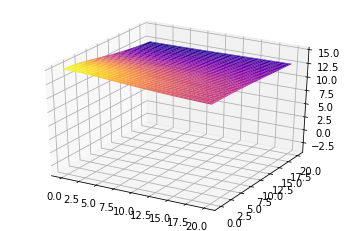

In [201]:



# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, all_fits[12], cmap='plasma')
cset = ax.contourf(X, Y, Z-all_fits[12], zdir='z', offset=-4, cmap='plasma')
ax.set_zlim(-4,np.max(fit))
plt.show()

